# Action-Conditioned Harmonic Oscillator


To introduce actions and turn this into a **World Model** (Action-Conditioned Prediction), the simplest physical modification is to treat the action as an **External Force** ($F_{ext}$) applied to the oscillator.

The equation of motion becomes:
$$m\ddot{x} + c\dot{x} + kx = \mathbf{F_{action}}$$

### The "World Model" Setup

1.  **Discrete Actions:** We define 3 discrete actions:
    -   **Action 0:** Push Left ($F = -5$)
    -   **Action 1:** Do Nothing ($F = 0$)
    -   **Action 2:** Push Right ($F = +5$)
2.  **Zero-Order Hold:** We assume the chosen action is applied as a **constant force** for the duration of the single time step ($dt=0.1s$).
3.  **Conditioning:** All models (Direct, TFM, Consistency) now receive the **History** (to infer damping $c$) AND the **Current Action** (to calculate the new force).

### Key Visualization: "The Fork"

To prove this is a world model, the visualization at the end will demonstrate **Counterfactuals**: starting from the _same_ history, we will simulate two different futures by forcing the model to take different actions.


In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from tqdm import tqdm


# ==========================================
# 1. PHYSICS ENGINE WITH FORCING
# ==========================================
class ForcedOscillator:
    def __init__(self, m=1.0, k=1.0, force_range=(-1, 1)):
        self.m, self.k = m, k
        self.force_range = force_range

        # Map Action Index -> Force Value
        self.force_map = {
            0: self.force_range[0],  # left
            1: 0.0,  # none
            2: self.force_range[1],  # right
        }

    def dynamics(self, t, state, c, force):
        """
        m*a = F_action - c*v - k*x
        """
        x, v = state[..., 0], state[..., 1]
        dxdt = v
        dvdt = (force - (self.k * x) - (c * v)) / self.m
        return torch.stack([dxdt, dvdt], dim=-1)

    def step(self, state, c, action_idx, dt=0.1):
        f_val = self.force_map[action_idx]

        def func(t, s):
            return self.dynamics(t, s, c, f_val)

        # Integrate over one step with CONSTANT force
        next_state = odeint(
            func, state, torch.tensor([0.0, dt]), method="dopri5"
        )[-1]
        return next_state


# ==========================================
# 2. DATASET GENERATION (Random Walk Policy)
# ==========================================
def generate_action_data(
    n_samples=1000,
    history_len=4,
    steps=20,
    dt=0.1,
    c_range=(0.1, 4.0),
    m=1.0,
    k=1.0,
    force_range=(-1, 1),
):
    physics = ForcedOscillator(m=m, k=k, force_range=force_range)
    data = []

    print(f"Generating {n_samples} trajectories with random actions...")

    for _ in range(n_samples):
        c = np.random.uniform(c_range[0], c_range[1])  # Hidden parameter
        state = torch.tensor([1.0, 0.0])

        # Generate a trajectory sequence
        traj = [state]
        actions = []

        for _ in range(steps):
            # Random Action
            a = np.random.randint(0, 3)
            next_s = physics.step(state, c, a, dt=dt)

            traj.append(next_s)
            actions.append(a)
            state = next_s

        # Create dataset samples
        traj = torch.stack(traj)

        for i in range(len(traj) - history_len - 1):
            # Input: History [t-4 ... t]
            hist = traj[i : i + history_len]

            current = traj[i + history_len]

            # Input: Action taken at time t
            action_t = actions[i + history_len]

            # Target: State at t+1
            target = traj[i + history_len + 1]

            data.append(
                {
                    "history": hist.flatten().float(),
                    "current": current.float(),
                    "action": torch.tensor(action_t).long(),
                    "target": target.float(),
                    "c": c,
                }
            )

    return data


# ==========================================
# 3. ACTION-CONDITIONED MODEL
# ==========================================
class WorldModelMLP(nn.Module):
    def __init__(self, history_dim, action_dim=3, hidden_dim=128):
        super().__init__()

        self.action_emb = nn.Embedding(action_dim, 16)

        # Input: History + Current + Action_Emb + Time_Tau
        # History Dim includes the current state flattened in it
        input_dim = history_dim + 2 + 16 + 1

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 2),
        )

    def forward(self, history, current_state, action, t):
        # Embed Action
        a = self.action_emb(action)
        if t.dim() == 1:
            t = t.unsqueeze(-1)

        # Concatenate: [History, Current_Sim_State, Action, Time]
        x = torch.cat([history, current_state, a, t], dim=-1)
        return self.net(x)


# ==========================================
# 4. TRAINING LOOP
# ==========================================
def train_world_models(
    dataset, batch_size=64, lr=1e-3, epochs=100, history_len=4, verbose=False
):
    HISTORY_STEPS = history_len
    HIST_DIM = HISTORY_STEPS * 2

    # split dataset into train and test
    len_dataset = len(dataset)
    perm = np.random.permutation(len_dataset)
    train_indices = perm[: int(len_dataset * 0.8)]
    test_indices = perm[int(len_dataset * 0.8) :]
    train_dataset = [dataset[i] for i in train_indices]
    test_dataset = [dataset[i] for i in test_indices]

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )

    # Instantiate Models
    direct = WorldModelMLP(HIST_DIM)
    tfm = WorldModelMLP(HIST_DIM)
    cons = WorldModelMLP(HIST_DIM)

    opt_d = optim.Adam(direct.parameters(), lr=lr)
    opt_t = optim.Adam(tfm.parameters(), lr=lr)
    opt_c = optim.Adam(cons.parameters(), lr=lr)

    def train_step(batch):
        h = batch["history"]
        curr = batch["current"]
        act = batch["action"]
        targ = batch["target"]
        B = curr.shape[0]

        zeros = torch.zeros(B, 1)

        # 1. Direct
        pred_d = direct(h, curr, act, zeros)
        loss_d = ((pred_d - targ) ** 2).mean()
        opt_d.zero_grad()
        loss_d.backward()
        opt_d.step()

        # 2. TFM (Flow Matching)
        tau = torch.rand(B, 1)
        x_tau = (1 - tau) * curr + tau * targ

        # TFM must know which action is driving the flow
        pred_tfm = tfm(h, x_tau, act, tau)
        loss_t = ((pred_tfm - targ) ** 2).mean()
        opt_t.zero_grad()
        loss_t.backward()
        opt_t.step()

        # 3. Consistency
        def teacher_dynamics(t_scalar, x_state):
            # Expand inputs for batch
            t_vec = torch.ones(B, 1) * t_scalar
            with torch.no_grad():
                pred_tgt = tfm(h, x_state, act, t_vec)
                v = (pred_tgt - x_state) / (1.0 - t_scalar + 1e-5)
            return v

        with torch.no_grad():
            teacher_out = odeint(
                teacher_dynamics,
                curr,
                torch.linspace(0.0, 1.0, 10),
                method="euler",
            )[-1]

        pred_c = cons(h, curr, act, zeros)
        loss_c = ((pred_c - teacher_out) ** 2).mean()
        opt_c.zero_grad()
        loss_c.backward()
        opt_c.step()

        return loss_d, loss_t, loss_c

    @torch.no_grad()
    def test_step(batch):
        h = batch["history"]
        curr = batch["current"]
        act = batch["action"]
        targ = batch["target"]
        B = curr.shape[0]

        zeros = torch.zeros(B, 1)

        # 1. Direct
        pred_d = direct(h, curr, act, zeros)
        loss_d = ((pred_d - targ) ** 2).mean()

        # 2. TFM (Flow Matching)
        tau = torch.rand(B, 1)
        x_tau = (1 - tau) * curr + tau * targ

        # TFM must know which action is driving the flow
        pred_tfm = tfm(h, x_tau, act, tau)
        loss_t = ((pred_tfm - targ) ** 2).mean()

        # 3. Consistency
        def teacher_dynamics(t_scalar, x_state):
            # Expand inputs for batch
            t_vec = torch.ones(B, 1) * t_scalar
            with torch.no_grad():
                pred_tgt = tfm(h, x_state, act, t_vec)
                v = (pred_tgt - x_state) / (1.0 - t_scalar + 1e-5)
            return v

        with torch.no_grad():
            teacher_out = odeint(
                teacher_dynamics,
                curr,
                torch.linspace(0.0, 1.0, 10),
                method="euler",
            )[-1]

        pred_c = cons(h, curr, act, zeros)
        loss_c = ((pred_c - teacher_out) ** 2).mean()

        return loss_d, loss_t, loss_c

    epoch = epoch_loss_d = epoch_loss_t = epoch_loss_c = 0
    pbar = tqdm(
        range(1, epochs + 1),
        desc=f"Epoch {epoch} | Dir: {epoch_loss_d:.4f} | TFM: {epoch_loss_t:.4f} | Cons: {epoch_loss_c:.4f}",
    )
    for epoch in pbar:
        d_losses, t_losses, c_losses = [], [], []
        for batch in train_loader:
            loss_d, loss_t, loss_c = train_step(batch)

            d_losses.append(loss_d.item())
            t_losses.append(loss_t.item())
            c_losses.append(loss_c.item())

        epoch_loss_d = sum(d_losses) / len(d_losses)
        epoch_loss_t = sum(t_losses) / len(t_losses)
        epoch_loss_c = sum(c_losses) / len(c_losses)

        pbar.set_description(
            f"Epoch {epoch} | Dir: {epoch_loss_d:.4f} | TFM: {epoch_loss_t:.4f} | Cons: {epoch_loss_c:.4f}"
        )
        if verbose:
            print(
                f"Epoch {epoch} | Dir: {epoch_loss_d:.4f} | TFM: {epoch_loss_t:.4f} | Cons: {epoch_loss_c:.4f}",
                flush=True,
            )

    # test
    print("Running Test Set Evaluation...")
    total_test_loss_d, total_test_loss_t, total_test_loss_c = 0, 0, 0
    for batch in test_loader:
        loss_d, loss_t, loss_c = test_step(batch)
        total_test_loss_d += loss_d.item()
        total_test_loss_t += loss_t.item()
        total_test_loss_c += loss_c.item()
    total_test_loss_d /= len(test_loader)
    total_test_loss_t /= len(test_loader)
    total_test_loss_c /= len(test_loader)

    print(
        f"Test Dir: {total_test_loss_d:.4f} | Test TFM: {total_test_loss_t:.4f} | Test Cons: {total_test_loss_c:.4f}"
    )

    return direct, tfm, cons


# ==========================================
# 5. VISUALIZATION (COUNTERFACTUALS)
# ==========================================
def visualize_forks(
    direct,
    tfm,
    cons,
    steps=100,
    dt=0.1,
    c=0.5,
    online=False,
    history_len=4,
    force_range=(-1, 1),
):
    print("\nGenerating Counterfactual Visualization...")
    physics = ForcedOscillator(force_range=force_range)

    # 1. Burn-in a history (C=1.0)
    state = torch.tensor([1.0, 0.0])
    hist_traj = [state]
    # No actions for first few steps to establish baseline
    for _ in range(history_len):
        state = physics.step(state, c=c, action_idx=1)  # Action 1 = None
        hist_traj.append(state)

    hist_tensor = torch.stack(hist_traj[:history_len]).flatten().unsqueeze(0)
    current_state = hist_traj[-1].unsqueeze(0)

    # 2. Fork the Paths
    actions = [0, 1, 2]  # Left, None, Right
    labels = ["Push Left (-)", "Do Nothing (0)", "Push Right (+)"]
    colors = ["r", "k", "b"]

    # plt.figure(figsize=(10, 6))
    fig, ax = plt.subplots(4, 1, figsize=(12, 8))

    # Plot History
    hist_x = [s[0].item() for s in hist_traj]
    for i in range(len(ax)):
        ax[i].plot(range(len(hist_x)), hist_x, "k-o", label="History")

    # Predict next step for each action
    for i, act_idx in enumerate(actions):
        act_tensor = torch.tensor([act_idx])
        zeros = torch.zeros(1, 1)

        gt_next_state = physics.step(current_state, c=c, action_idx=act_idx)
        gt_next_state = gt_next_state[0, 0].item()

        # Use Consistency Model for fast prediction
        with torch.no_grad():
            next_state_cons = cons(
                hist_tensor, current_state, act_tensor, zeros
            )

        # direct model
        next_state_direct = direct(
            hist_tensor, current_state, act_tensor, zeros
        )

        # tfm model
        def dynamics(t, s):
            t_vec = torch.ones(1, 1) * t
            with torch.no_grad():
                tgt = tfm(hist_tensor, s, act_tensor, t_vec)
            return (tgt - s) / (1.0 - t + 1e-5)

        next_state_tfm = odeint(
            dynamics,
            current_state,
            torch.linspace(0.0, 1.0, 10),
            method="euler",
        )[-1]

        # Plot the jump
        t_next = len(hist_x) - 1 + 1  # Next time step index
        x_next_cons = next_state_cons[0, 0].item()
        x_next_direct = next_state_direct[0, 0].item()
        x_next_tfm = next_state_tfm[0, 0].item()

        ax[0].plot(
            [len(hist_x) - 1, t_next],
            [hist_x[-1], x_next_cons],
            f"{colors[i]}--",
            linewidth=2,
        )
        ax[0].scatter(
            [t_next],
            [x_next_cons],
            c=colors[i],
            s=100,
            marker="*",
            label=f"Action: {labels[i]}",
        )

        ax[1].plot(
            [len(hist_x) - 1, t_next],
            [hist_x[-1], x_next_direct],
            f"{colors[i]}--",
            linewidth=2,
        )
        ax[1].scatter(
            [t_next],
            [x_next_direct],
            c=colors[i],
            s=100,
            marker="*",
            label=f"Action: {labels[i]}",
        )
        ax[2].plot(
            [len(hist_x) - 1, t_next],
            [hist_x[-1], x_next_tfm],
            f"{colors[i]}--",
            linewidth=2,
        )
        ax[2].scatter(
            [t_next],
            [x_next_tfm],
            c=colors[i],
            s=100,
            marker="*",
            label=f"Action: {labels[i]}",
        )
        ax[3].plot(
            [len(hist_x) - 1, t_next],
            [hist_x[-1], gt_next_state],
            "g--",
            linewidth=2,
        )
        ax[3].scatter(
            [t_next],
            [gt_next_state],
            c=colors[i],
            s=100,
            marker="o",
            label=f"Ground Truth Action: {labels[i]}",
        )

    ax[0].set_title("Counterfactuals: Consistency Model")
    ax[1].set_title("Counterfactuals: Direct Model")
    ax[2].set_title("Counterfactuals: TFM Model")
    ax[3].set_title("Counterfactuals: Ground Truth")
    for i in range(len(ax)):
        ax[i].set_xlabel("Step")
        ax[i].set_ylabel("Position")
        ax[i].legend()
        ax[i].grid(True, alpha=0.3)
    plt.show()

In [11]:
dataset = generate_action_data(
    n_samples=1000,
    steps=20,
)

Generating 1000 trajectories with random actions...


In [12]:
d_model, tfm_model, cons_model = train_world_models(dataset, epochs=100)


Starting Training...
Ep 20 | Dir: 0.0167 | TFM: 0.0258 | Cons: 0.0294
Ep 40 | Dir: 0.0100 | TFM: 0.0072 | Cons: 0.0218
Ep 60 | Dir: 0.0057 | TFM: 0.0075 | Cons: 0.0115
Ep 80 | Dir: 0.0052 | TFM: 0.0059 | Cons: 0.0019
Ep 100 | Dir: 0.0027 | TFM: 0.0031 | Cons: 0.0012



Generating Counterfactual Visualization...


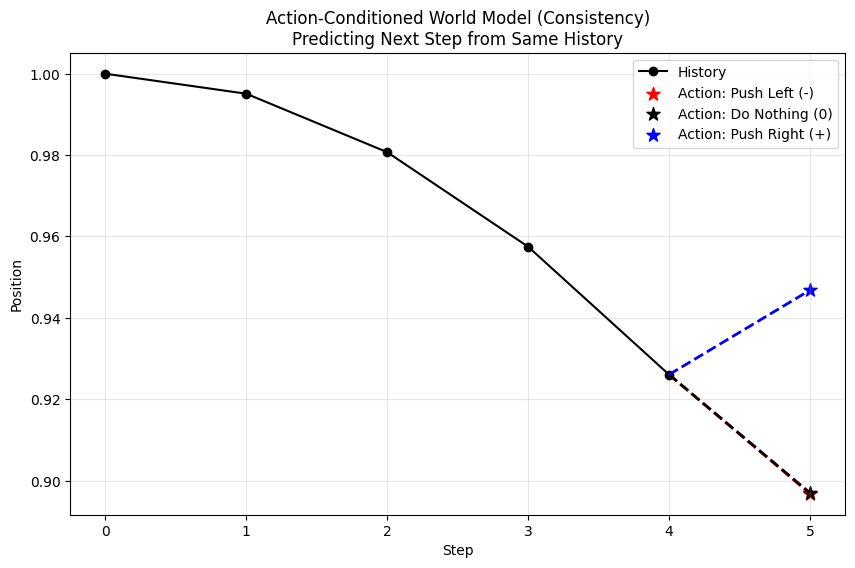

In [15]:
visualize_forks(d_model, tfm_model, cons_model)


Generating Counterfactual Visualization...


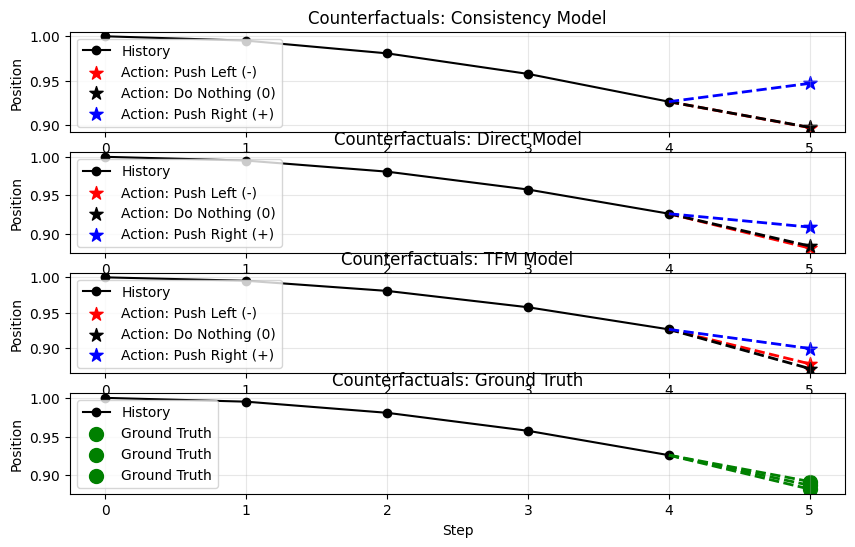

In [23]:
visualize_forks(d_model, tfm_model, cons_model)


Generating Counterfactual Visualization...


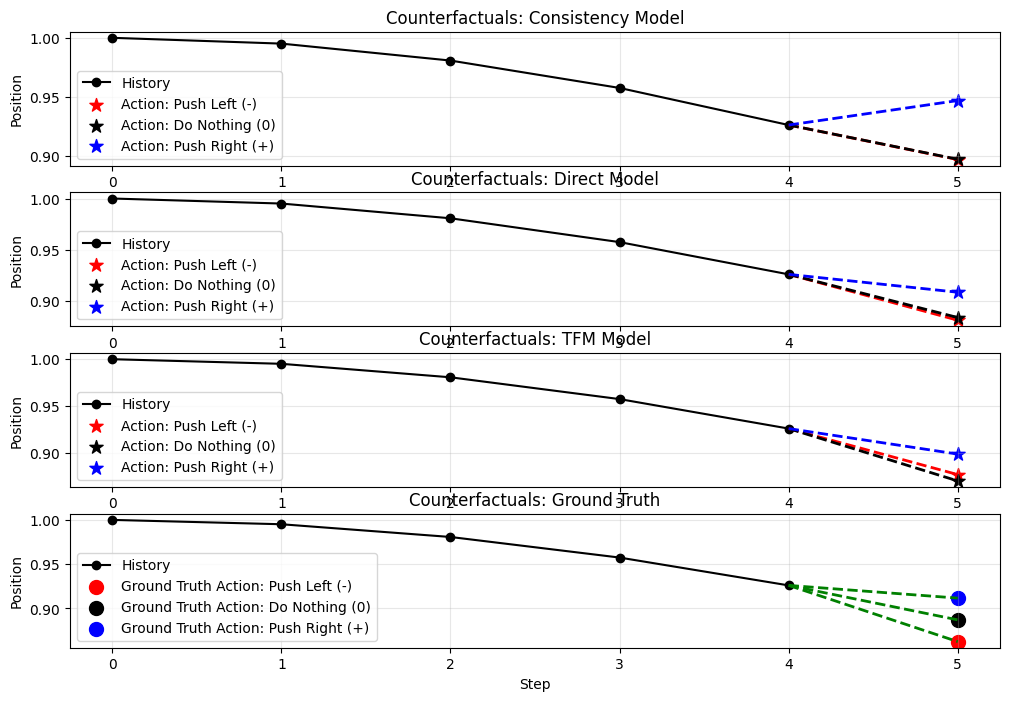

In [30]:
visualize_forks(d_model, tfm_model, cons_model, force_range=(-5, 5))

### Train longer

Goal: see if the models can capture all three actions



Starting Training...
Ep 20 | Dir: 0.0198 | TFM: 0.0291 | Cons: 0.0031
Ep 40 | Dir: 0.0072 | TFM: 0.0122 | Cons: 0.0173
Ep 60 | Dir: 0.0041 | TFM: 0.0056 | Cons: 0.0113
Ep 80 | Dir: 0.0026 | TFM: 0.0042 | Cons: 0.0038
Ep 100 | Dir: 0.0018 | TFM: 0.0030 | Cons: 0.0026
Ep 120 | Dir: 0.0015 | TFM: 0.0028 | Cons: 0.0023
Ep 140 | Dir: 0.0015 | TFM: 0.0022 | Cons: 0.0019
Ep 160 | Dir: 0.0011 | TFM: 0.0018 | Cons: 0.0044
Ep 180 | Dir: 0.0010 | TFM: 0.0016 | Cons: 0.0033
Ep 200 | Dir: 0.0010 | TFM: 0.0019 | Cons: 0.0028
Ep 220 | Dir: 0.0007 | TFM: 0.0010 | Cons: 0.0007
Ep 240 | Dir: 0.0008 | TFM: 0.0009 | Cons: 0.0016
Ep 260 | Dir: 0.0006 | TFM: 0.0009 | Cons: 0.0012
Ep 280 | Dir: 0.0004 | TFM: 0.0005 | Cons: 0.0014
Ep 300 | Dir: 0.0006 | TFM: 0.0007 | Cons: 0.0012
Ep 320 | Dir: 0.0005 | TFM: 0.0007 | Cons: 0.0023
Ep 340 | Dir: 0.0006 | TFM: 0.0006 | Cons: 0.0011
Ep 360 | Dir: 0.0006 | TFM: 0.0005 | Cons: 0.0016
Ep 380 | Dir: 0.0004 | TFM: 0.0005 | Cons: 0.0019
Ep 400 | Dir: 0.0006 | TFM: 0.00

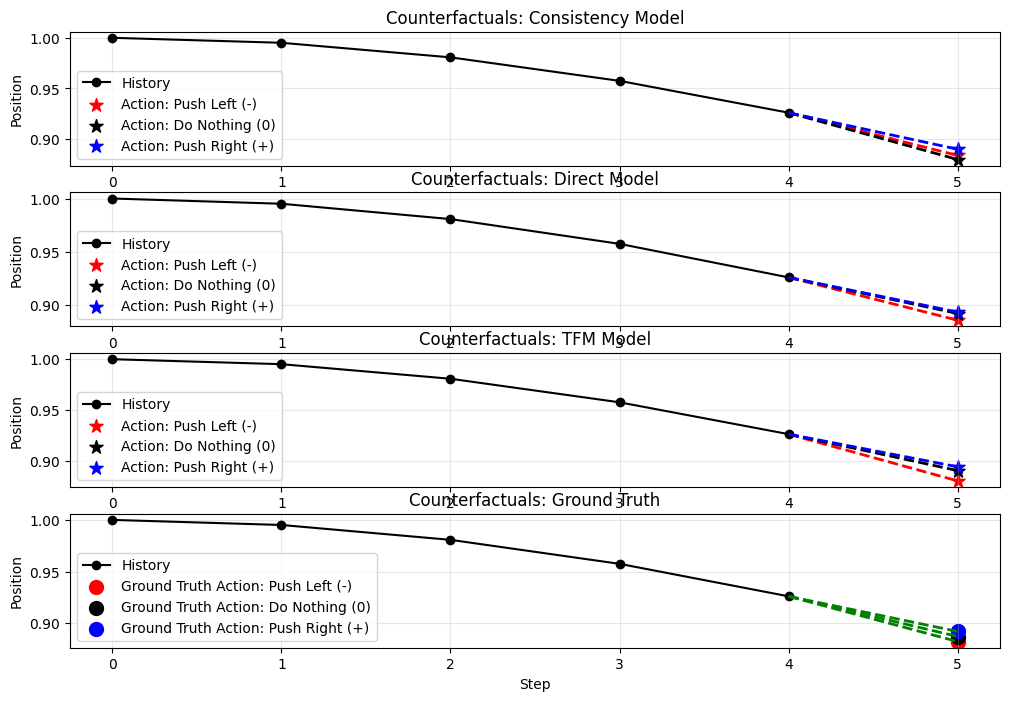

In [31]:
d_model_longer, tfm_model_longer, cons_model_longer = train_world_models(
    dataset, epochs=1000
)
visualize_forks(d_model_longer, tfm_model_longer, cons_model_longer)

## Higher Force Range


Generating 1000 trajectories with random actions...

Starting Training...
Ep 20 | Dir: 0.0751 | TFM: 0.0910 | Cons: 0.0819
Ep 40 | Dir: 0.0249 | TFM: 0.0254 | Cons: 0.0510
Ep 60 | Dir: 0.0149 | TFM: 0.0156 | Cons: 0.0453
Ep 80 | Dir: 0.0068 | TFM: 0.0097 | Cons: 0.0199
Ep 100 | Dir: 0.0042 | TFM: 0.0065 | Cons: 0.0066
Ep 120 | Dir: 0.0033 | TFM: 0.0059 | Cons: 0.0080
Ep 140 | Dir: 0.0040 | TFM: 0.0075 | Cons: 0.0090
Ep 160 | Dir: 0.0039 | TFM: 0.0062 | Cons: 0.0057
Ep 180 | Dir: 0.0033 | TFM: 0.0068 | Cons: 0.0133
Ep 200 | Dir: 0.0042 | TFM: 0.0056 | Cons: 0.0077
Ep 220 | Dir: 0.0022 | TFM: 0.0050 | Cons: 0.0083
Ep 240 | Dir: 0.0030 | TFM: 0.0050 | Cons: 0.0109
Ep 260 | Dir: 0.0035 | TFM: 0.0086 | Cons: 0.0044
Ep 280 | Dir: 0.0033 | TFM: 0.0069 | Cons: 0.0019
Ep 300 | Dir: 0.0032 | TFM: 0.0046 | Cons: 0.0045
Ep 320 | Dir: 0.0030 | TFM: 0.0037 | Cons: 0.0043
Ep 340 | Dir: 0.0024 | TFM: 0.0051 | Cons: 0.0262
Ep 360 | Dir: 0.0047 | TFM: 0.0048 | Cons: 0.0047
Ep 380 | Dir: 0.0028 | TFM: 0.

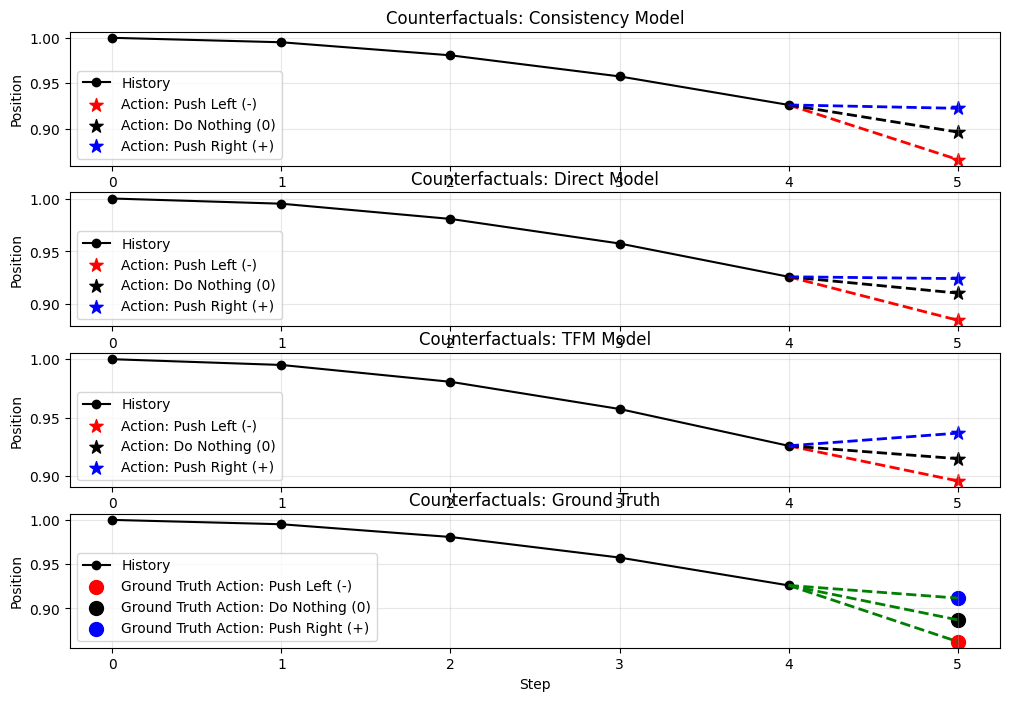

In [33]:
dataset_higher = generate_action_data(
    n_samples=1000,
    steps=20,
    force_range=(-5, 5),
)
d_model_higher, tfm_model_higher, cons_model_higher = train_world_models(
    dataset_higher, epochs=500
)
visualize_forks(
    d_model_higher, tfm_model_higher, cons_model_higher, force_range=(-5, 5)
)

In [ ]:
def visualize_unroll(
    direct,
    tfm,
    cons,
    treatment={0: 10, 1: 5, 2: 10},
    dt=0.1,
    c=0.5,
    history_len=4,
    force_range=(-1, 1),
):
    physics = ForcedOscillator(force_range=force_range)

    # 1. Warmup History (Ground Truth)
    state = torch.tensor([1.0, 0.0])
    hist_traj = [state]
    for _ in range(history_len):  # 4 steps warmup
        state = physics.step(state, c, 1)  # Action 1 = None
        hist_traj.append(state)

    # 2. Define Action Sequence for Future
    # Let's do a complex sequence: Wait, Push Left, Wait, Push Right
    actions = (
        [1] * treatment[1]  # Wait
        + [0] * treatment[0]  # Push Left
        + [1] * treatment[1]  # Wait
        + [2] * treatment[2]  # Push Right
    )

    # 3. Generate Ground Truth Future
    gt_future = []
    curr = hist_traj[-1]
    for a in actions:
        nxt = physics.step(curr, c, a, dt)
        gt_future.append(nxt)
        curr = nxt
    gt_future = torch.stack(gt_future).numpy()

    # 4. Unroll Models
    models = {"Direct": direct, "TFM": tfm, "Consistency": cons}
    preds = {k: [] for k in models}

    # Initial History Tensor [1, (H+1)*2]
    # We must maintain separate history buffers for each model to allow drift
    initial_hist_flat = torch.stack(hist_traj).flatten().unsqueeze(0)

    hist_buffers = {
        k: torch.stack(hist_traj) for k in models
    }  # List of tensors

    for step, act_idx in enumerate(actions):
        act_tensor = torch.tensor([act_idx])
        zeros = torch.zeros(1, 1)

        for name, model in models.items():
            # Prepare Input
            # History buffer: [5, 2]. Flatten -> [1, 10]
            curr_hist_tensor = (
                hist_buffers[name][:history_len].flatten().unsqueeze(0)
            )
            curr_state_tensor = hist_buffers[name][-1].unsqueeze(0)

            # Predict Next State
            with torch.no_grad():
                if name == "TFM":
                    # Solver Loop
                    def dynamics(t, s):
                        t_vec = torch.ones(1, 1) * t
                        tgt = model(curr_hist_tensor, s, act_tensor, t_vec)
                        return (tgt - s) / (1.0 - t + 1e-5)

                    next_state = odeint(
                        dynamics,
                        curr_state_tensor,
                        torch.linspace(0.0, 1.0, int(1 // dt)),
                        method="euler",
                    )[-1]
                else:
                    # One-Shot
                    next_state = model(
                        curr_hist_tensor, curr_state_tensor, act_tensor, zeros
                    )

            # Store Prediction
            preds[name].append(next_state[0].numpy())

            # Update History (Autoregressive Step)
            # Remove oldest (idx 0), add new at end
            old_buff = hist_buffers[name]  # [5, 2]
            new_buff = torch.cat([old_buff[1:], next_state], dim=0)  # [5, 2]
            hist_buffers[name] = new_buff

    # 5. Plotting
    preds = {k: np.array(v) for k, v in preds.items()}
    time_steps = np.arange(len(gt_future))

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Position
    ax[0].plot(
        time_steps,
        gt_future[:, 0],
        "k-",
        linewidth=3,
        alpha=0.3,
        label="Ground Truth",
    )
    for name, p in preds.items():
        style = "--" if name == "Direct" else ("-o" if name == "TFM" else ":x")
        ax[0].plot(time_steps, p[:, 0], style, label=name)
    ax[0].set_title(f"Autoregressive Position Unroll ({len(actions)} Steps)")
    ax[0].set_ylabel("Position")
    ax[0].legend()

    # Velocity (Phase Space check)
    ax[1].plot(
        time_steps,
        gt_future[:, 1],
        "k-",
        linewidth=3,
        alpha=0.3,
        label="Ground Truth",
    )
    for name, p in preds.items():
        style = "--" if name == "Direct" else ("-o" if name == "TFM" else ":x")
        ax[1].plot(time_steps, p[:, 1], style, label=name)
    ax[1].set_title("Autoregressive Velocity Unroll")
    ax[1].set_ylabel("Velocity")

    plt.tight_layout()
    plt.show()

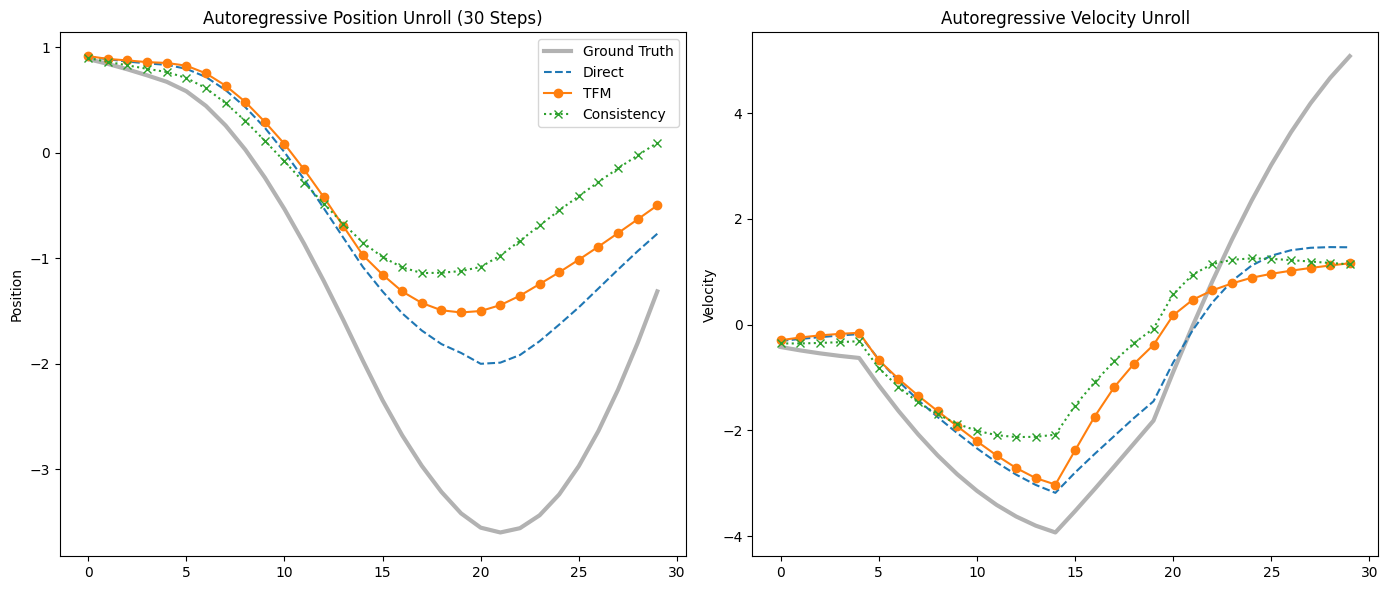

In [35]:
visualize_unroll(
    d_model_higher,
    tfm_model_higher,
    cons_model_higher,
    treatment={0: 10, 1: 5, 2: 10},
    force_range=(-5, 5),
)

In [52]:
dataset_higher = generate_action_data(
    n_samples=100,
    steps=30,
    force_range=(-5, 5),
)

Generating 100 trajectories with random actions...


In [60]:
d_model_higher, tfm_model_higher, cons_model_higher = train_world_models(
    dataset_higher, epochs=100
)

Epoch 100 | Dir: 0.0020 | TFM: 0.0009 | Cons: 0.0033: 100%|██████████| 100/100 [00:10<00:00,  9.50it/s]

Running Test Set Evaluation...
Test Dir: 0.0020 | Test TFM: 0.0010 | Test Cons: 0.0028


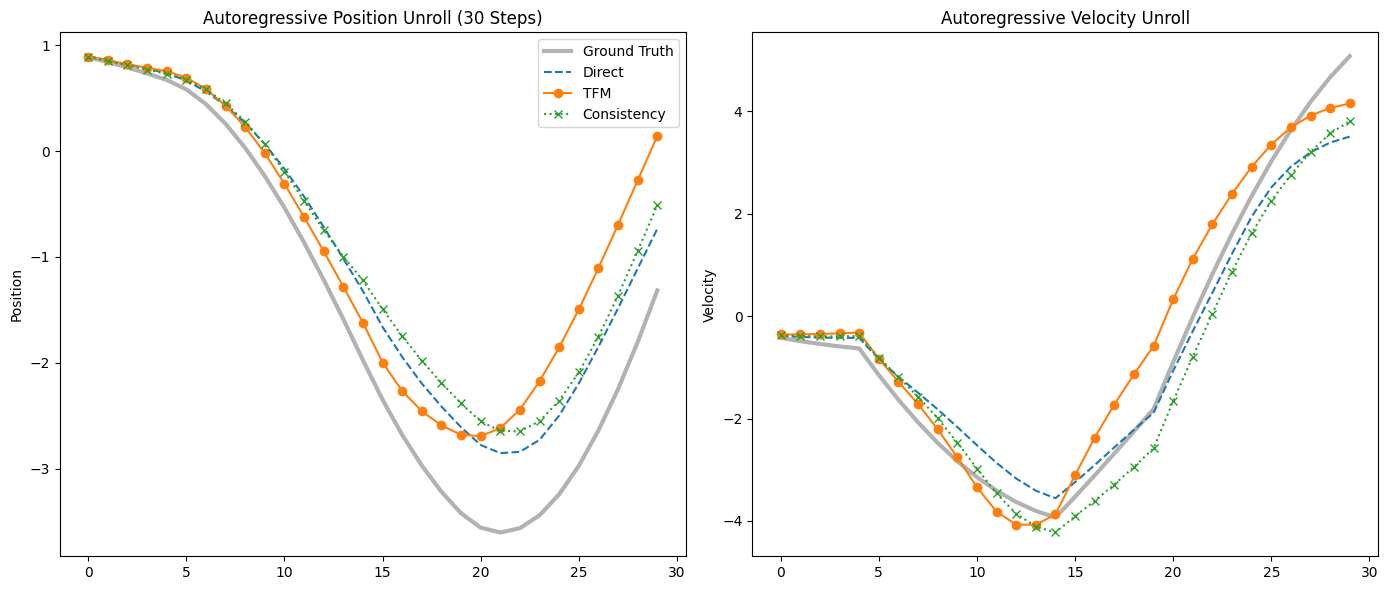

In [61]:
visualize_unroll(
    d_model_higher,
    tfm_model_higher,
    cons_model_higher,
    treatment={0: 10, 1: 5, 2: 10},
    force_range=(-5, 5),
)

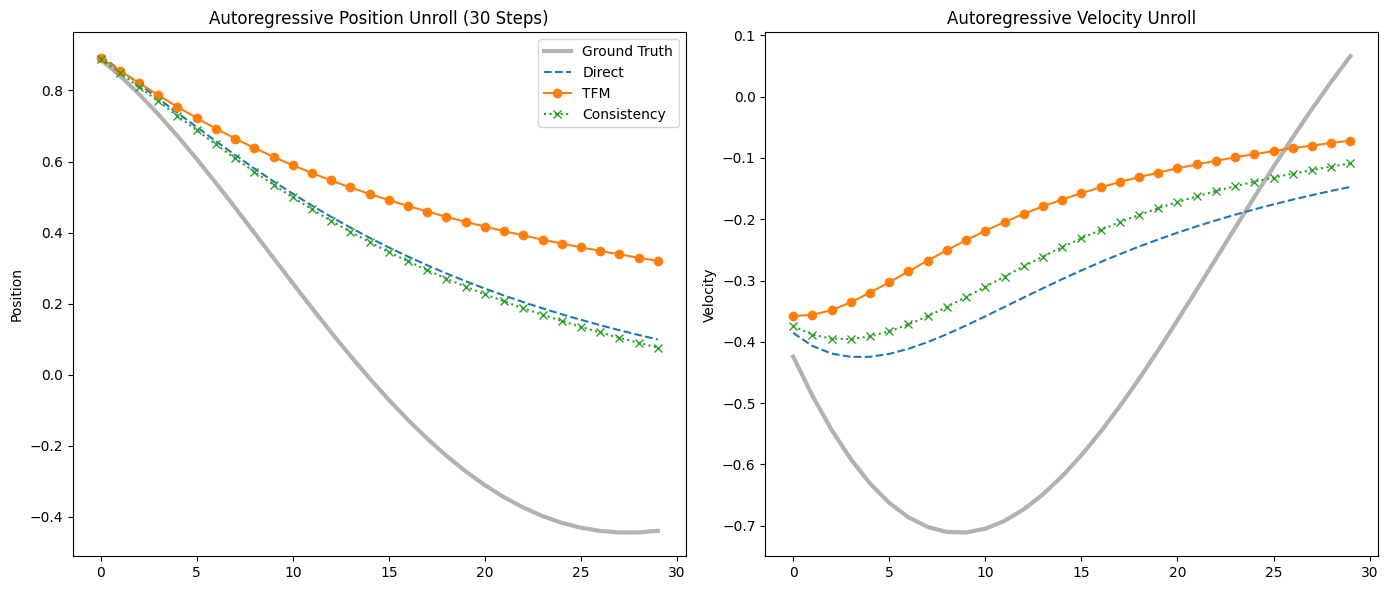

In [62]:
visualize_unroll(
    d_model_higher,
    tfm_model_higher,
    cons_model_higher,
    treatment={0: 0, 1: 15, 2: 0},
    force_range=(-5, 5),
)

## Training with longer sequences

First get good performance on the position curve using one step prediction. Then test jump steps


In [63]:
dataset_100 = generate_action_data(
    n_samples=500,
    steps=100,
    force_range=(-10, 10),
)

Generating 500 trajectories with random actions...


In [64]:
len(dataset_100)

48000

In [66]:
d_model_longer, tfm_model_longer, cons_model_longer = train_world_models(
    dataset_100,
    epochs=100,
    batch_size=32,
    lr=1e-4,
)

Epoch 100 | Dir: 0.0032 | TFM: 0.0019 | Cons: 0.0025: 100%|██████████| 100/100 [05:53<00:00,  3.53s/it]


Running Test Set Evaluation...
Test Dir: 0.0032 | Test TFM: 0.0018 | Test Cons: 0.0010


### No jump inteventions


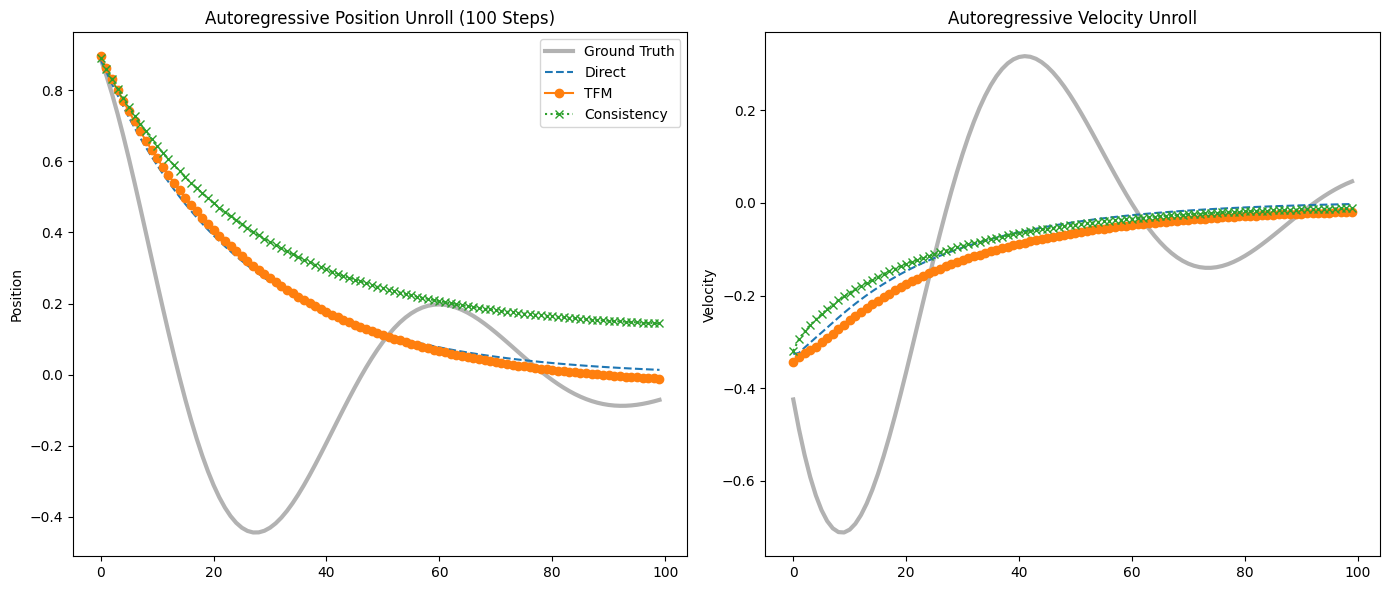

In [67]:
visualize_unroll(
    d_model_longer,
    tfm_model_longer,
    cons_model_longer,
    treatment={0: 0, 1: 50, 2: 0},
    force_range=(-10, 10),
)

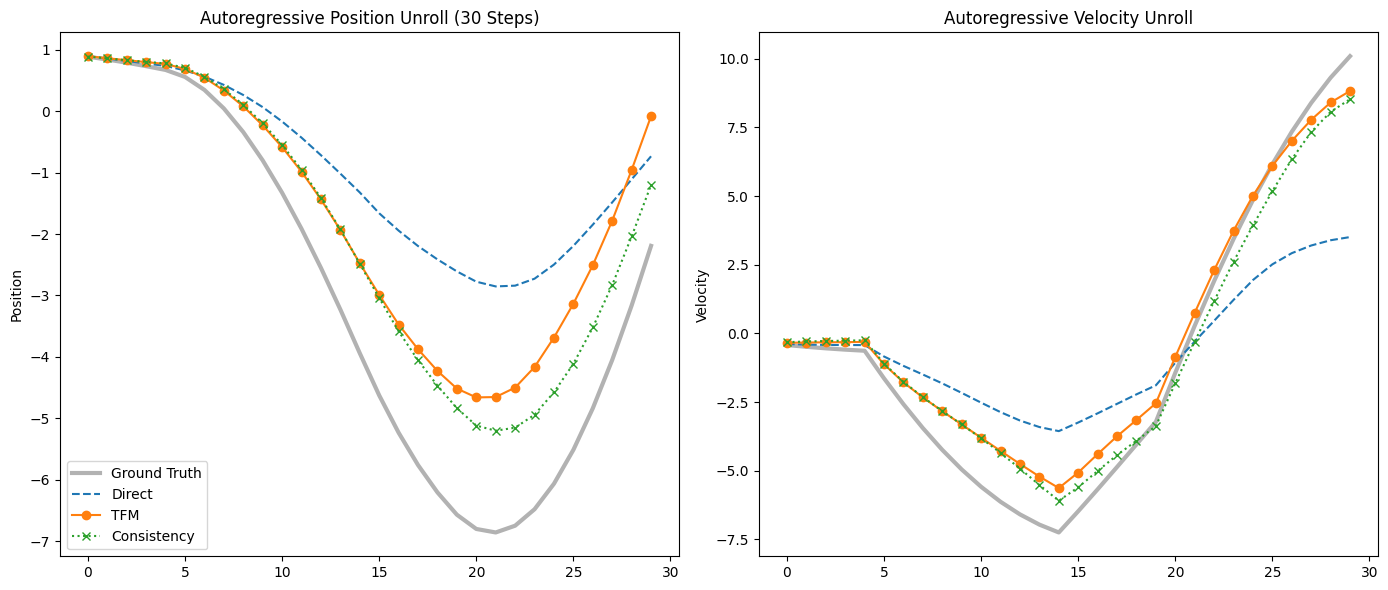

In [70]:
visualize_unroll(
    d_model_higher,
    tfm_model_longer,
    cons_model_longer,
    treatment={0: 10, 1: 5, 2: 10},
    force_range=(-10, 10),
)

### Longer history to see more curviture


In [72]:
dataset_200_h10 = generate_action_data(
    n_samples=500,
    steps=200,
    force_range=(-10, 10),
    history_len=10,
)
d_model_200_h10, tfm_model_200_h10, cons_model_200_h10 = train_world_models(
    dataset_200_h10,
    epochs=100,
    batch_size=32,
    lr=1e-4,
    history_len=10,
)

Generating 500 trajectories with random actions...


Epoch 100 | Dir: 0.0035 | TFM: 0.0018 | Cons: 0.0030: 100%|██████████| 100/100 [11:34<00:00,  6.94s/it]


Running Test Set Evaluation...
Test Dir: 0.0034 | Test TFM: 0.0017 | Test Cons: 0.0021


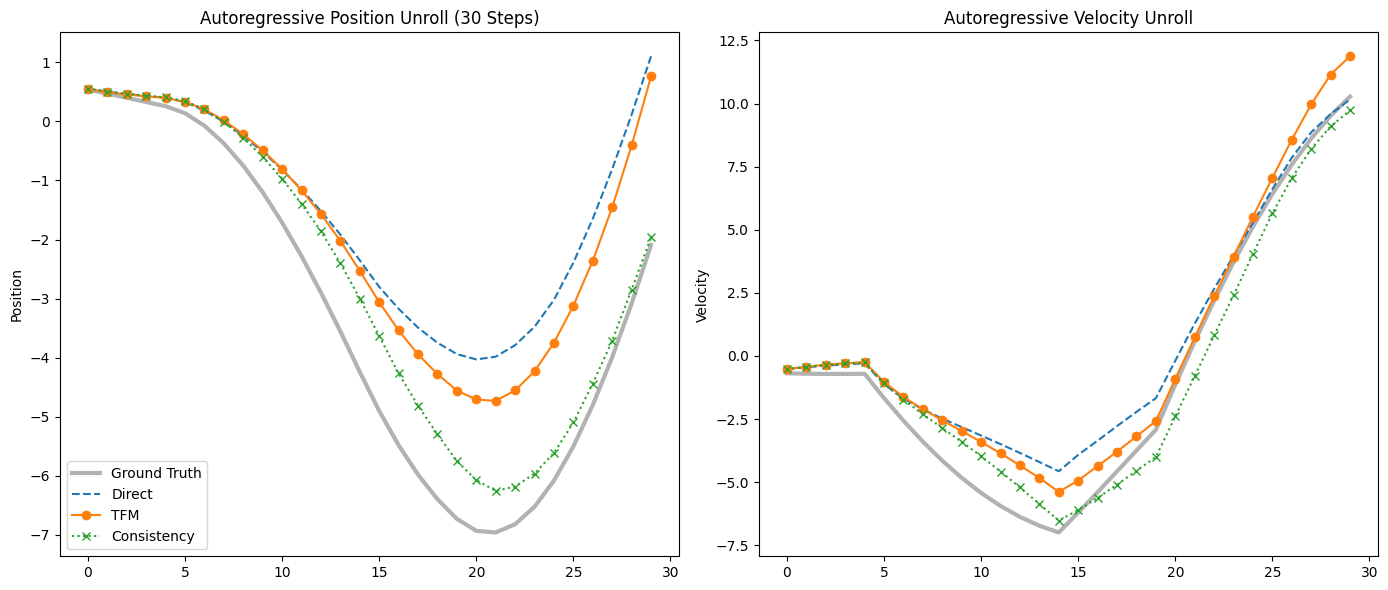

In [73]:
visualize_unroll(
    d_model_200_h10,
    tfm_model_200_h10,
    cons_model_200_h10,
    treatment={0: 10, 1: 5, 2: 10},
    force_range=(-10, 10),
    history_len=10,
)


Generating Counterfactual Visualization...


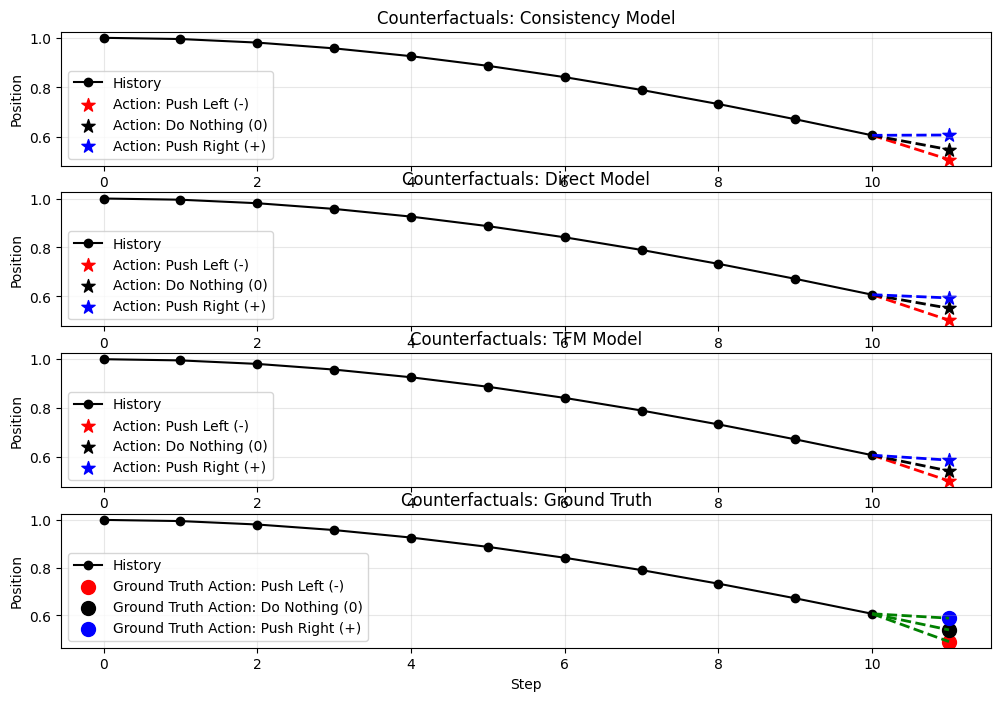

In [74]:
visualize_forks(
    d_model_200_h10,
    tfm_model_200_h10,
    cons_model_200_h10,
    force_range=(-10, 10),
    history_len=10,
)

### Test on unseen dt values

Trained on dt=0.1


#### dt=0.5


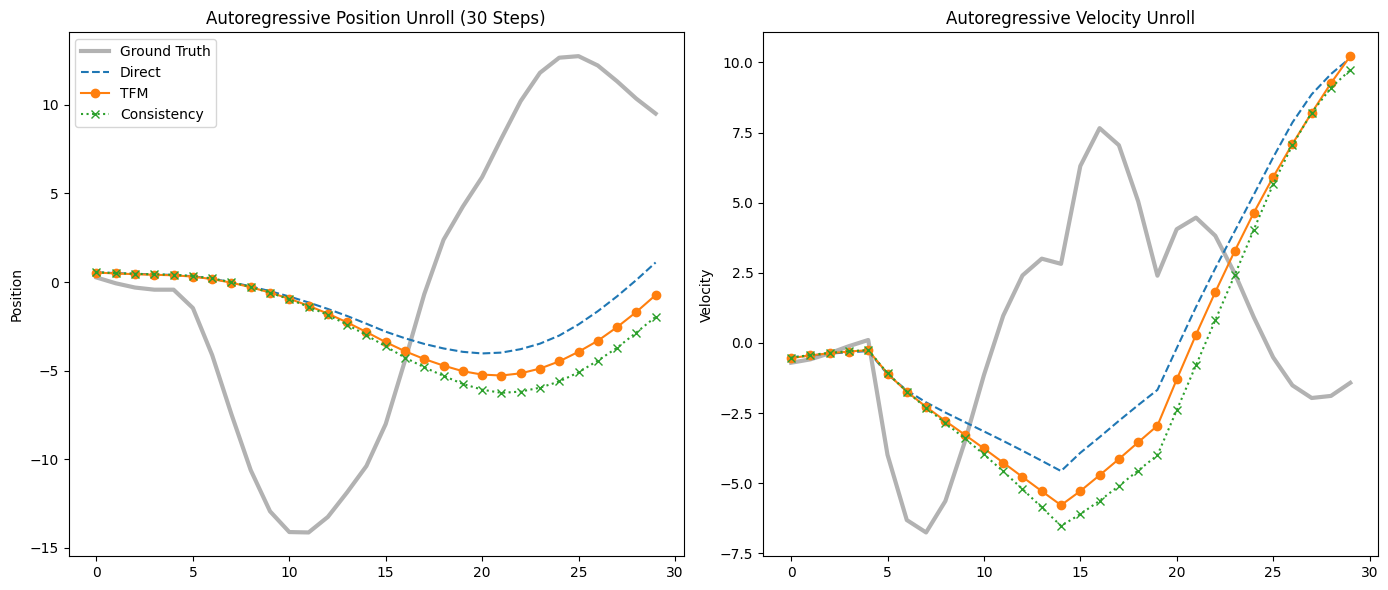

In [78]:
visualize_unroll(
    d_model_200_h10,
    tfm_model_200_h10,
    cons_model_200_h10,
    treatment={0: 10, 1: 5, 2: 10},
    force_range=(-10, 10),
    history_len=10,
    dt=0.5,
)

#### dt=0.01


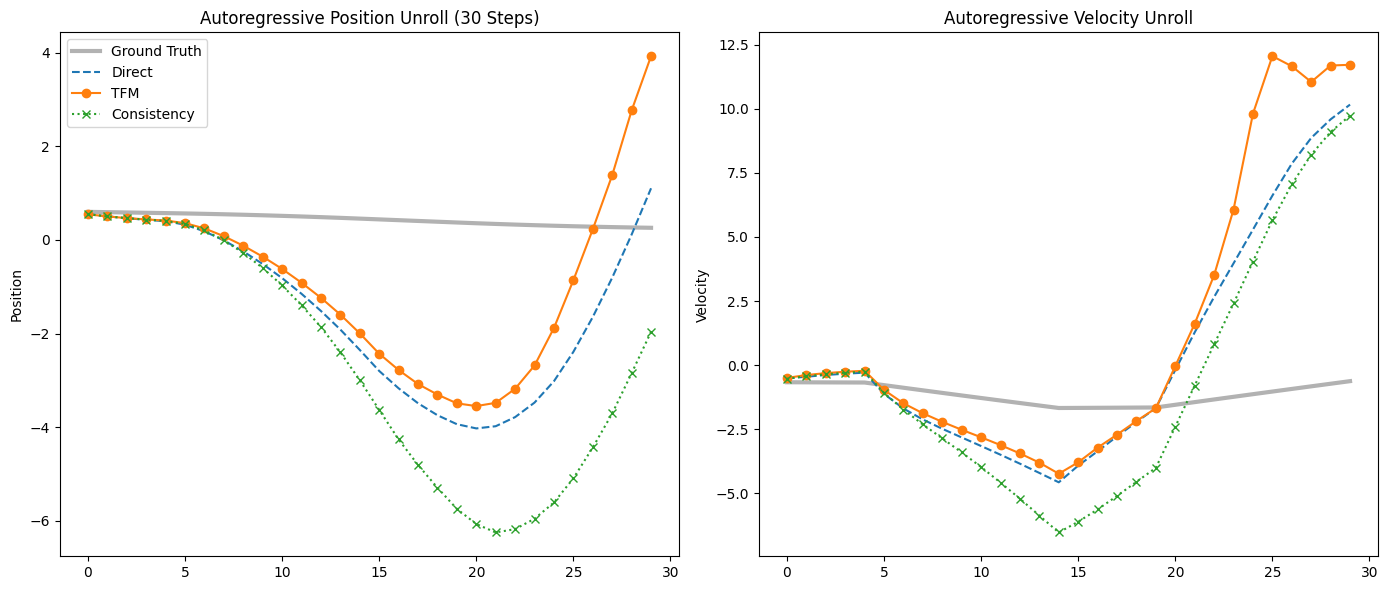

In [79]:
visualize_unroll(
    d_model_200_h10,
    tfm_model_200_h10,
    cons_model_200_h10,
    treatment={0: 10, 1: 5, 2: 10},
    force_range=(-10, 10),
    history_len=10,
    dt=0.01,
)

#### dt=1


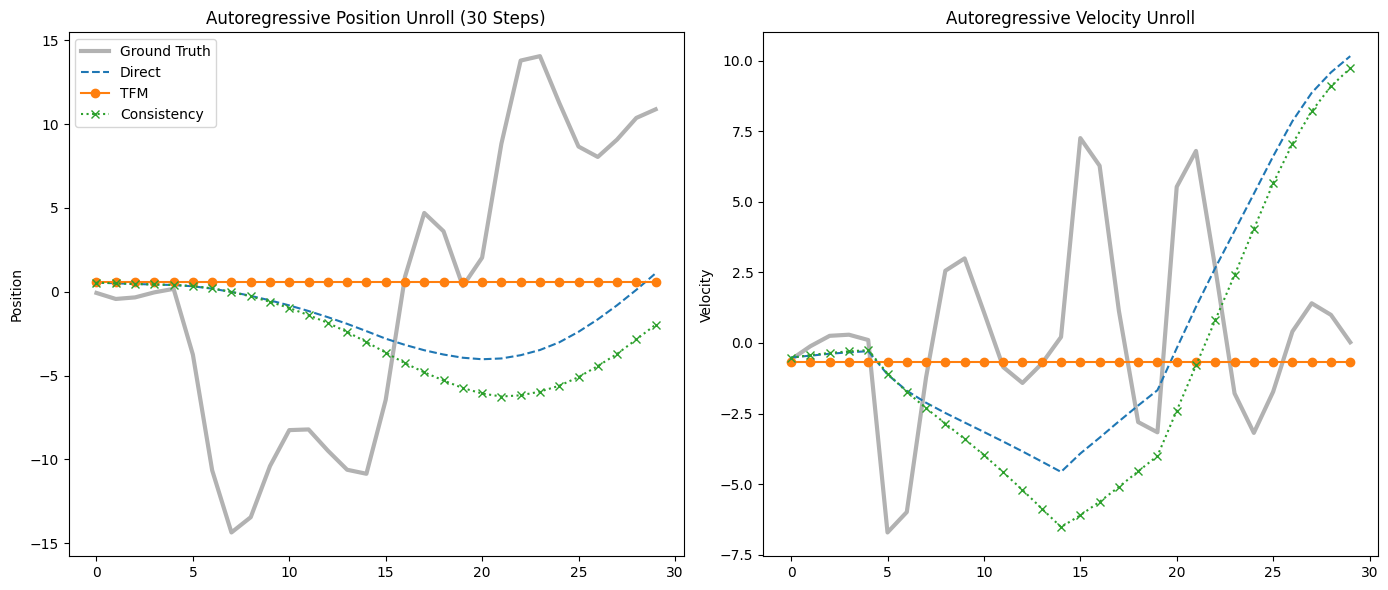

In [80]:
visualize_unroll(
    d_model_200_h10,
    tfm_model_200_h10,
    cons_model_200_h10,
    treatment={0: 10, 1: 5, 2: 10},
    force_range=(-10, 10),
    history_len=10,
    dt=1,
)

#### dt=0.2


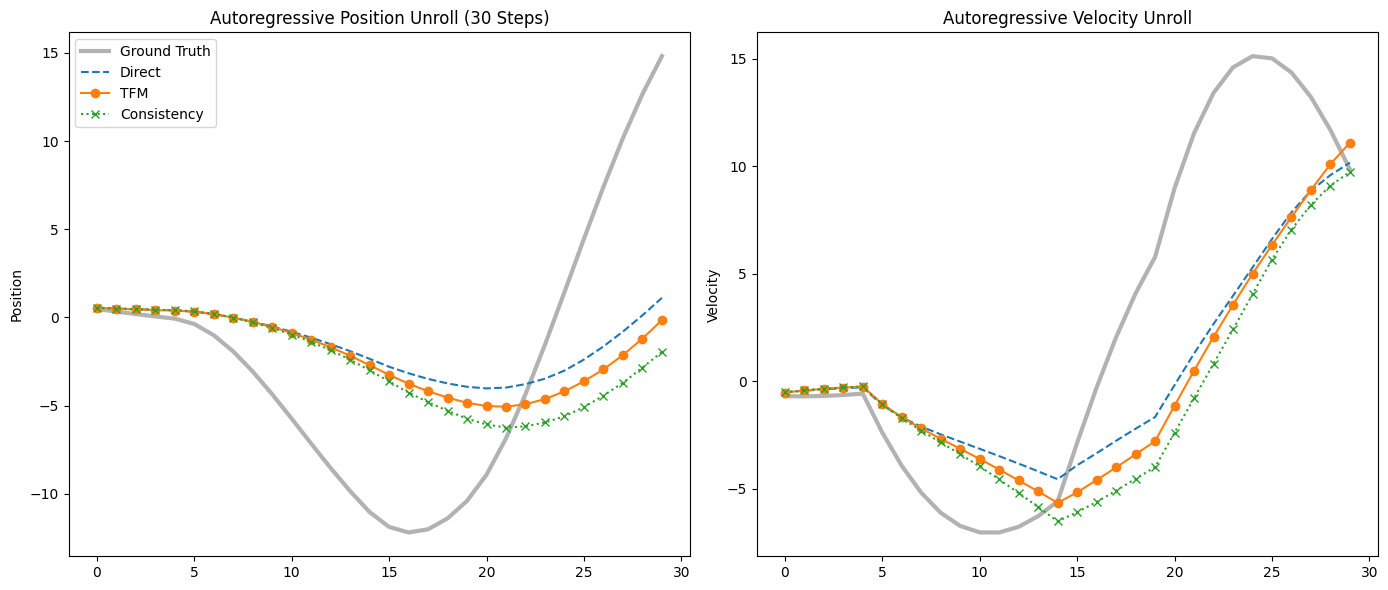

In [81]:
visualize_unroll(
    d_model_200_h10,
    tfm_model_200_h10,
    cons_model_200_h10,
    treatment={0: 10, 1: 5, 2: 10},
    force_range=(-10, 10),
    history_len=10,
    dt=0.2,
)

## Random Action Policies


In [84]:
def generate_action_trajectory_data(
    n_samples=1000,
    history_len=4,
    steps=20,
    dt=0.1,
    c_range=(0.1, 4.0),
    m=1.0,
    k=1.0,
    force_range=(-1, 1),
    min_action_duration=3,
    max_action_duration=8,
):
    physics = ForcedOscillator(m=m, k=k, force_range=force_range)
    data = []

    print(f"Generating {n_samples} trajectories with structured policies...")

    for _ in range(n_samples):
        c = np.random.uniform(c_range[0], c_range[1])  # Hidden parameter
        state = torch.tensor([1.0, 0.0])

        # Generate a trajectory sequence
        traj = [state]
        actions = []

        # Policy State
        current_action = np.random.randint(0, 3)
        steps_remaining = 0

        for _ in range(steps):
            # If previous action duration expired, pick a new action and duration
            if steps_remaining <= 0:
                current_action = np.random.randint(0, 3)
                steps_remaining = np.random.randint(
                    min_action_duration, max_action_duration + 1
                )

            # Use current sticky action
            a = current_action
            steps_remaining -= 1

            next_s = physics.step(state, c, a, dt=dt)

            traj.append(next_s)
            actions.append(a)
            state = next_s

        # Create dataset samples
        traj = torch.stack(traj)

        for i in range(len(traj) - history_len - 1):
            # Input: History [t-4 ... t]
            hist = traj[i : i + history_len]

            current = traj[i + history_len]

            # Input: Action taken at time t
            action_t = actions[i + history_len]

            # Target: State at t+1
            target = traj[i + history_len + 1]

            data.append(
                {
                    "history": hist.flatten().float(),
                    "current": current.float(),
                    "action": torch.tensor(action_t).long(),
                    "target": target.float(),
                    "c": c,
                }
            )

    return data

In [85]:
dataset_200_h10_policy = generate_action_trajectory_data(
    n_samples=500,
    steps=200,
    force_range=(-10, 10),
    history_len=10,
)
d_model_200_h10_policy, tfm_model_200_h10_policy, cons_model_200_h10_policy = (
    train_world_models(
        dataset_200_h10_policy,
        epochs=100,
        batch_size=32,
        lr=1e-4,
        history_len=10,
    )
)

Generating 500 trajectories with structured policies...


Epoch 100 | Dir: 0.0048 | TFM: 0.0036 | Cons: 0.0144: 100%|██████████| 100/100 [11:35<00:00,  6.96s/it]


Running Test Set Evaluation...
Test Dir: 0.0041 | Test TFM: 0.0030 | Test Cons: 0.0137


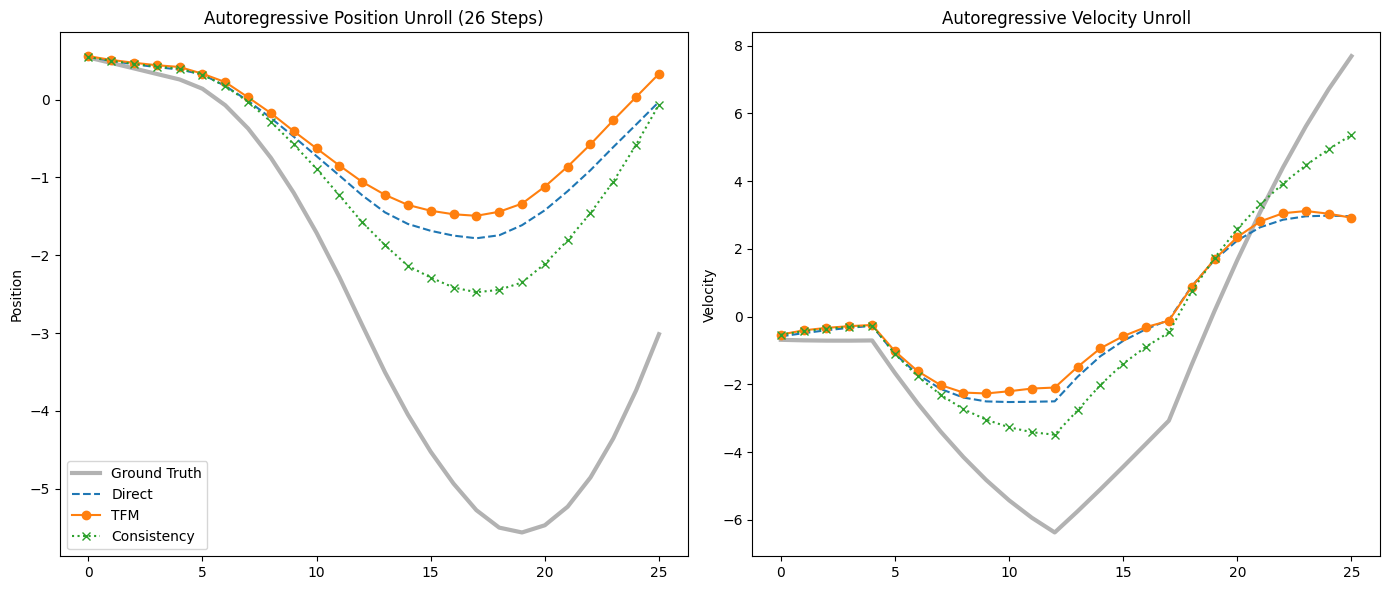

In [86]:
visualize_unroll(
    d_model_200_h10_policy,
    tfm_model_200_h10_policy,
    cons_model_200_h10_policy,
    treatment={0: 8, 1: 5, 2: 8},
    force_range=(-10, 10),
    history_len=10,
    dt=0.1,
)

### Verify if c is constant in dataset, it will overfit


In [87]:
dataset_200_h10_policy_c_constant = generate_action_trajectory_data(
    n_samples=500,
    steps=200,
    force_range=(-10, 10),
    history_len=10,
    c_range=(0.5, 0.5),
)
(
    d_model_200_h10_policy_c_constant,
    tfm_model_200_h10_policy_c_constant,
    cons_model_200_h10_policy_c_constant,
) = train_world_models(
    dataset_200_h10_policy_c_constant,
    epochs=100,
    batch_size=32,
    lr=1e-4,
    history_len=10,
)

Generating 500 trajectories with structured policies...


Epoch 100 | Dir: 0.0003 | TFM: 0.0005 | Cons: 0.0033: 100%|██████████| 100/100 [11:38<00:00,  6.99s/it]


Running Test Set Evaluation...
Test Dir: 0.0002 | Test TFM: 0.0006 | Test Cons: 0.0054


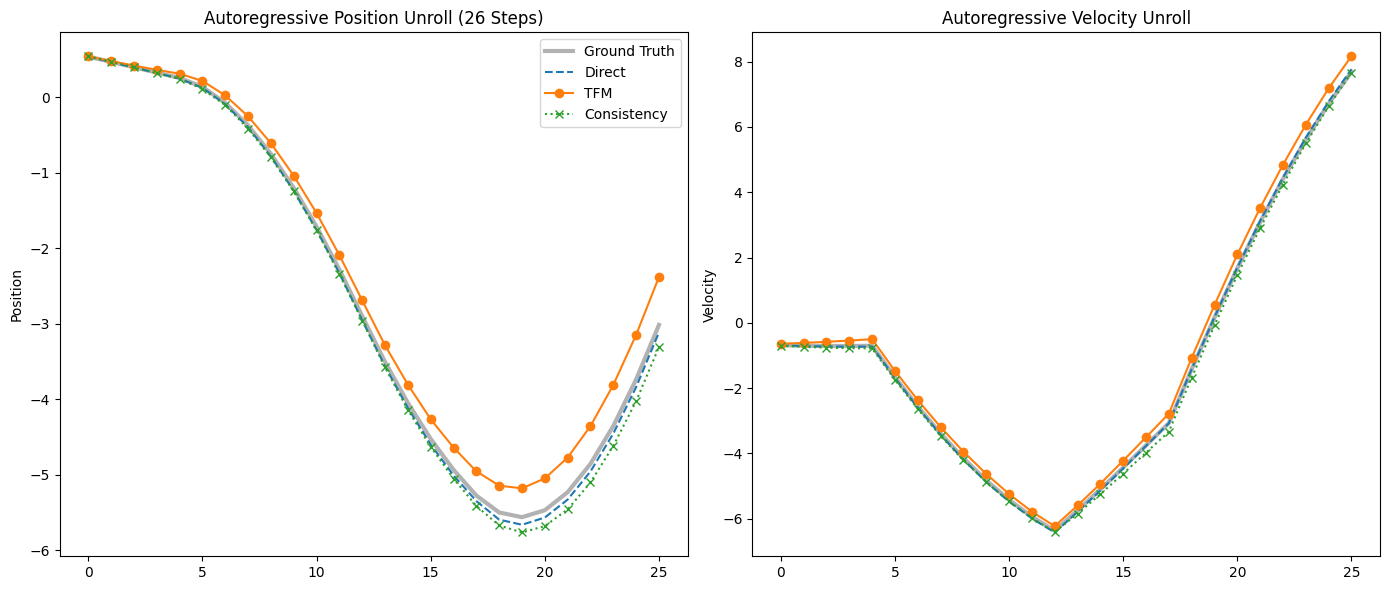

In [88]:
visualize_unroll(
    d_model_200_h10_policy_c_constant,
    tfm_model_200_h10_policy_c_constant,
    cons_model_200_h10_policy_c_constant,
    treatment={0: 8, 1: 5, 2: 8},
    force_range=(-10, 10),
    history_len=10,
    dt=0.1,
)

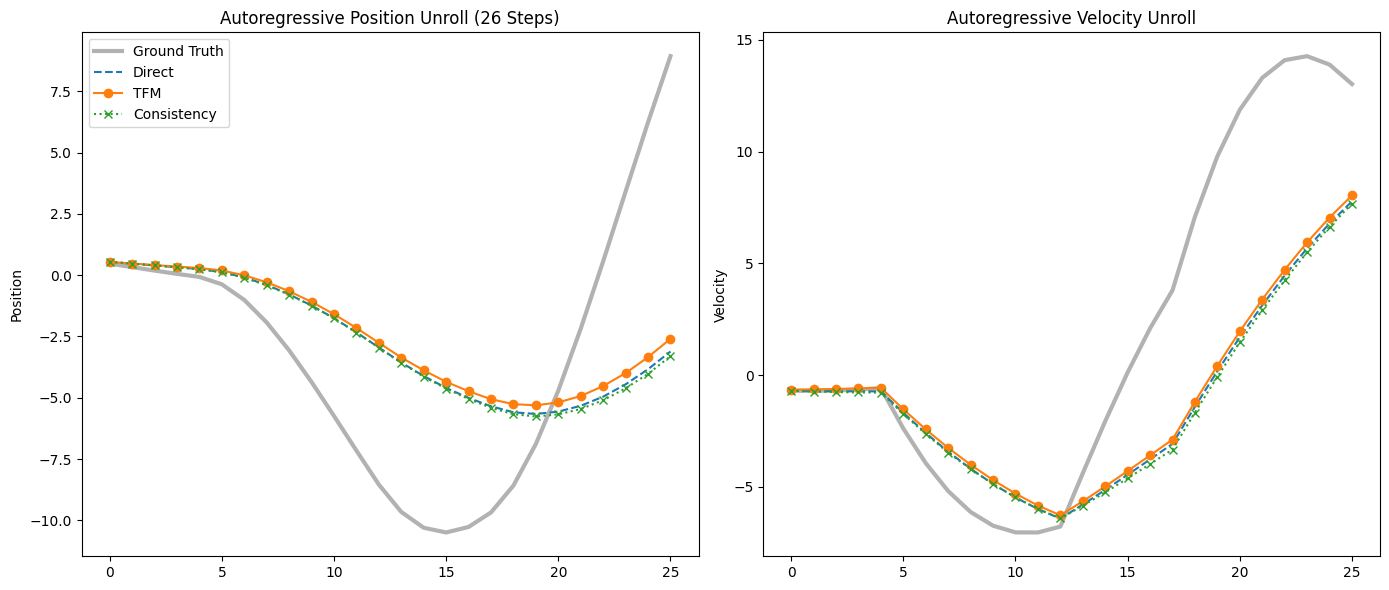

In [89]:
visualize_unroll(
    d_model_200_h10_policy_c_constant,
    tfm_model_200_h10_policy_c_constant,
    cons_model_200_h10_policy_c_constant,
    treatment={0: 8, 1: 5, 2: 8},
    force_range=(-10, 10),
    history_len=10,
    dt=0.2,
)

# Second-Order Action-Conditioned Trajectory Matching


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from tqdm import tqdm


# ==========================================
# 1. PHYSICS ENGINE (Ground Truth)
# ==========================================
class ForcedOscillator:
    def __init__(self, m=1.0, k=1.0, force_range=(-10, 10)):
        self.m, self.k = m, k
        self.force_range = force_range
        # Map Action Index -> Force Value
        self.force_map = {0: -1.0, 1: 0.0, 2: 1.0}  # Left, None, Right

    def step(self, state, c, action_idx, dt=0.1):
        """
        Precise integration of the ground truth physics
        state: [x, v]
        """
        f_val = self.force_map[action_idx]

        def dynamics(t, s):
            x, v = s[..., 0], s[..., 1]
            dxdt = v
            # m*a = F_action - c*v - k*x
            dvdt = (f_val - (self.k * x) - (c * v)) / self.m
            return torch.stack([dxdt, dvdt], dim=-1)

        # Integrate exactly one step
        next_state = odeint(
            dynamics, state, torch.tensor([0.0, dt]), method="dopri5"
        )[-1]
        return next_state


# ==========================================
# 2. DATASET (Sequence Generation)
# ==========================================
class SequenceDataset(Dataset):
    def __init__(
        self,
        n_seqs=200,
        seq_len=20,
        dt=0.1,
        m=1.0,
        k=1.0,
        force_range=(-10, 10),
        c_range=(0.1, 2.0),
    ):
        self.data = []
        physics = ForcedOscillator(m=m, k=k, force_range=force_range)

        print(f"Generating {n_seqs} sequences of length {seq_len}...")

        for _ in range(n_seqs):
            # Randomize Damping per sequence to force model to generalize
            c = np.random.uniform(c_range[0], c_range[1])
            state = torch.tensor([np.random.uniform(-1, 1), 0.0])

            states = [state]
            actions = []

            # Generate Sequence
            for _ in range(seq_len):
                a = np.random.randint(0, 3)
                state = physics.step(state, c, a, dt)
                states.append(state)
                actions.append(a)

            # Store: (States[0:T], Actions[0:T], States[1:T+1])
            self.data.append(
                {
                    "states": torch.stack(states[:-1]).float(),  # Inputs
                    "actions": torch.tensor(actions).long(),
                    "targets": torch.stack(states[1:]).float(),  # Next steps
                    "c": c,
                }
            )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# ==========================================
# 3. MODELS
# ==========================================


# --- Baseline: Discrete Jump Model (ResNet) ---
class JumpModel(nn.Module):
    """
    Learns x_{t+1} = x_t + f(x_t, a_t)
    Approximates dynamics as a discrete map (Chord).
    """

    def __init__(self, state_dim=2, action_dim=3):
        super().__init__()
        self.act_emb = nn.Embedding(action_dim, 8)
        self.net = nn.Sequential(
            nn.Linear(state_dim + 8, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, state_dim),  # Outputs Delta State
        )

    def forward(self, state, action):
        emb = self.act_emb(action)
        delta = self.net(torch.cat([state, emb], dim=-1))
        return state + delta


# --- Proposed: Second-Order ODE with Prior ---
class SecondOrderODENet(nn.Module):
    """
    Learns d/dt[x, v] = [v, Prior(a) + NN(x, v, a)]
    """

    def __init__(self, state_dim=2, action_dim=3):
        super().__init__()
        self.act_emb = nn.Embedding(action_dim, 8)

        # Neural Correction Term
        self.net = nn.Sequential(
            nn.Linear(state_dim + 8, 64),
            nn.Tanh(),  # Tanh is better for continuous physics
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),  # Output: Acceleration Correction
        )

        # Learnable weighting for the prior (optional)
        self.prior_scale = nn.Parameter(torch.tensor(1.0))

    def physics_prior(self, state, action_idx):
        """
        Rough Draft Physics: F = Action_Force - Damping*v
        We assume we don't know 'k' (spring constant) or exact 'c'.
        """
        v = state[..., 1:2]

        # Simple mapping: 0->-1, 1->0, 2->1
        force_vals = torch.tensor([-1.0, 0.0, 1.0], device=state.device)
        f_action = force_vals[action_idx].unsqueeze(-1)

        # Prior: Input force + some default damping
        return f_action - 0.1 * v

    def forward(self, t, state, action_emb, action_idx):
        x, v = state[..., 0:1], state[..., 1:2]

        # 1. Analytic Prior (The "Bending" Force)
        prior_acc = self.physics_prior(state, action_idx)

        # 2. Neural Correction
        nn_input = torch.cat([x, v, action_emb], dim=-1)
        correction_acc = self.net(nn_input)

        # 3. Total Acceleration
        # We start with the prior, NN fixes the errors
        total_acc = (self.prior_scale * prior_acc) + correction_acc

        return torch.cat([v, total_acc], dim=-1)


# Wrapper to handle ODESolve logic
class TrajectoryMatchingModel(nn.Module):
    def __init__(self, ode_func):
        super().__init__()
        self.ode_func = ode_func

    def forward(self, start_state, action_indices, dt=0.1):
        """
        Integrates one step forward using the ODE solver.
        Note: For training, we can integrate K steps if we want.
        """
        # We need to handle the embedding lookup here to pass to ODE func
        act_emb = self.ode_func.act_emb(action_indices)

        # Define dynamics closure for torchdiffeq
        # Note: torchdiffeq expects func(t, y)
        def func(t, y):
            return self.ode_func(t, y, act_emb, action_indices)

        # Integrate from t=0 to t=dt
        # Using RK4 for stability in training
        t_span = torch.tensor([0.0, dt], device=start_state.device)
        next_state = odeint(func, start_state, t_span, method="rk4")[-1]

        return next_state


# ==========================================
# 4. TRAINING LOOP
# ==========================================
def train_experiment(
    dataset, epochs=40, batch_size=32, lr=1e-3, verbose=False
):
    # split dataset into train and test
    len_dataset = len(dataset)
    perm = np.random.permutation(len_dataset)
    train_indices = perm[: int(len_dataset * 0.8)]
    test_indices = perm[int(len_dataset * 0.8) :]
    train_dataset = [dataset[i] for i in train_indices]
    test_dataset = [dataset[i] for i in test_indices]

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )

    # Models
    jump_model = JumpModel()

    ode_core = SecondOrderODENet()
    traj_model = TrajectoryMatchingModel(ode_core)

    opt_jump = optim.Adam(jump_model.parameters(), lr=lr)
    opt_traj = optim.Adam(traj_model.parameters(), lr=lr)

    def train_step(batch):
        states = batch["states"]  # [B, T, 2]
        actions = batch["actions"]  # [B, T]
        targets = batch["targets"]  # [B, T, 2]

        # --- 1. Train Jump Model (One-Step MSE) ---
        # Reshape to [B*T, ...] to treat every step as a sample
        B, T, D = states.shape
        flat_s = states.view(-1, D)
        flat_a = actions.view(-1)
        flat_t = targets.view(-1, D)

        pred_j = jump_model(flat_s, flat_a)
        loss_j = ((pred_j - flat_t) ** 2).mean()

        opt_jump.zero_grad()
        loss_j.backward()
        opt_jump.step()
        # total_j += loss_j.item()

        # --- 2. Train Trajectory Model (Sequential Shooting) ---
        # For efficiency in this demo, we simulate 1 step at a time but
        # preserve gradients through the solver.
        # Ideally, you shoot K steps, but 1-step shooting with ODE
        # is still valid Trajectory Matching (min horizon).

        pred_next = traj_model(flat_s, flat_a, dt=0.1)
        loss_t = ((pred_next - flat_t) ** 2).mean()

        # Regularize acceleration (optional, helps smoothness)
        # loss_t += 0.01 * (pred_next[:, 1]**2).mean()

        opt_traj.zero_grad()
        loss_t.backward()
        opt_traj.step()
        # total_t += loss_t.item()

        return loss_j, loss_t

    @torch.no_grad()
    def test_step(batch):
        states = batch["states"]  # [B, T, 2]
        actions = batch["actions"]  # [B, T]
        targets = batch["targets"]  # [B, T, 2]

        # --- 1. Train Jump Model (One-Step MSE) ---
        # Reshape to [B*T, ...] to treat every step as a sample
        B, T, D = states.shape
        flat_s = states.view(-1, D)
        flat_a = actions.view(-1)
        flat_t = targets.view(-1, D)

        pred_j = jump_model(flat_s, flat_a)
        loss_j = ((pred_j - flat_t) ** 2).mean()

        # --- 2. Train Trajectory Model (Sequential Shooting) ---
        pred_next = traj_model(flat_s, flat_a, dt=0.1)
        loss_t = ((pred_next - flat_t) ** 2).mean()

        # Regularize acceleration (optional, helps smoothness)
        loss_t += 0.01 * (pred_next[:, 1] ** 2).mean()

        return loss_j, loss_t

    print("Training Models...")
    pbar = tqdm(
        range(1, epochs + 1),
        desc=f"Epoch {1} | Jump Loss: 0.0000 | Traj Loss: 0.0000",
    )
    for epoch in range(1, epochs + 1):
        total_j, total_t = 0, 0

        for batch in train_loader:
            loss_j, loss_t = train_step(batch)
            total_j += loss_j.item()
            total_t += loss_t.item()
        epoch_loss_j = total_j / len(train_loader)
        epoch_loss_t = total_t / len(train_loader)
        pbar.set_description(
            f"Epoch {epoch} | Jump Loss: {epoch_loss_j:.4f} | Traj Loss: {epoch_loss_t:.4f}"
        )
        if verbose:
            print(
                f"Ep {epoch} | Jump Loss: {total_j:.4f} | Traj Loss: {total_t:.4f}",
                flush=True,
            )

    # test set
    print("Testing Models...")
    total_j, total_t = 0, 0
    for batch in test_loader:
        loss_j, loss_t = test_step(batch)
        total_j += loss_j.item()
        total_t += loss_t.item()
    test_loss_j = total_j / len(test_loader)
    test_loss_t = total_t / len(test_loader)
    print(
        f"Test | Jump Loss: {test_loss_j:.4f} | Traj Loss: {test_loss_t:.4f}"
    )

    return jump_model, traj_model


# ==========================================
# 5. VISUALIZATION (UNROLL)
# ==========================================
def visualize_trajectory_unroll(
    jump_model,
    traj_model,
    treatment={0: 15, 1: 10, 2: 15},  # Longer duration to see drift
    dt=0.1,
    c=0.3,
    force_range=(-10, 10),
):
    physics = ForcedOscillator(force_range=force_range)

    # 1. Warmup History
    state = torch.tensor([1.0, 0.0])
    # Ground truth initial state
    curr_gt = state
    curr_jump = state.unsqueeze(0)
    curr_traj = state.unsqueeze(0)

    # 2. Define Action Sequence
    # Wait, Push Left, Wait, Push Right
    actions = (
        [1] * treatment[1]
        + [0] * treatment[0]
        + [1] * treatment[1]
        + [2] * treatment[2]
    )

    gt_hist, jump_hist, traj_hist = [], [], []

    print(f"Simulating Unroll for {len(actions)} steps...")

    # 3. Unroll Loop
    for act_idx in actions:
        # A. Ground Truth Step
        curr_gt = physics.step(curr_gt, c, act_idx, dt)
        gt_hist.append(curr_gt.numpy())

        # B. Jump Model Step (Discrete Map)
        with torch.no_grad():
            act_tensor = torch.tensor([act_idx])
            curr_jump = jump_model(curr_jump, act_tensor)
            jump_hist.append(curr_jump[0].numpy())

        # C. Trajectory Matching Step (ODE Integrate)
        with torch.no_grad():
            act_tensor = torch.tensor([act_idx])
            # The model integrates forward 0.1s
            curr_traj = traj_model(curr_traj, act_tensor, dt=dt)
            traj_hist.append(curr_traj[0].numpy())

    # 4. Plotting
    gt_hist = np.array(gt_hist)
    jump_hist = np.array(jump_hist)
    traj_hist = np.array(traj_hist)

    t_steps = np.arange(len(actions))

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot Position
    ax[0].plot(
        t_steps, gt_hist[:, 0], "k-", lw=3, alpha=0.3, label="Ground Truth"
    )
    ax[0].plot(t_steps, jump_hist[:, 0], "r--", label="Jump Model (ResNet)")
    ax[0].plot(
        t_steps,
        traj_hist[:, 0],
        "b-o",
        markersize=4,
        label="2nd Order ODE (Ours)",
    )

    ax[0].set_title("Position Unroll (Action Bending)")
    ax[0].set_ylabel("Position X")
    ax[0].set_xlabel("Time Step")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # Plot Phase Space (Velocity vs Position)
    # This reveals if the physics are broken
    ax[1].plot(
        gt_hist[:, 0], gt_hist[:, 1], "k-", lw=3, alpha=0.3, label="GT Phase"
    )
    ax[1].plot(
        jump_hist[:, 0], jump_hist[:, 1], "r--", alpha=0.6, label="Jump Phase"
    )
    ax[1].plot(
        traj_hist[:, 0], traj_hist[:, 1], "b-", alpha=0.6, label="ODE Phase"
    )

    ax[1].set_title("Phase Space Trajectory (Pos vs Vel)")
    ax[1].set_xlabel("Position")
    ax[1].set_ylabel("Velocity")
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return gt_hist, jump_hist, traj_hist, t_steps

In [2]:
traj_dataset = SequenceDataset(
    n_seqs=200,
    seq_len=100,
    dt=0.1,
    m=1.0,
    k=1.0,
    c_range=(0.1, 0.1),
)

Generating 200 sequences of length 100...


In [3]:
jump_model, traj_model = train_experiment(
    traj_dataset, epochs=100, batch_size=32, lr=1e-4
)

Training Models...


Epoch 100 | Jump Loss: 0.0000 | Traj Loss: 0.0000:   0%|          | 0/100 [00:03<?, ?it/s]

Testing Models...
Test | Jump Loss: 0.0000 | Traj Loss: 0.0025


In [46]:
traj_model.ode_func.prior_scale

Parameter containing:
tensor(0.9953, requires_grad=True)

Simulating Unroll for 50 steps...


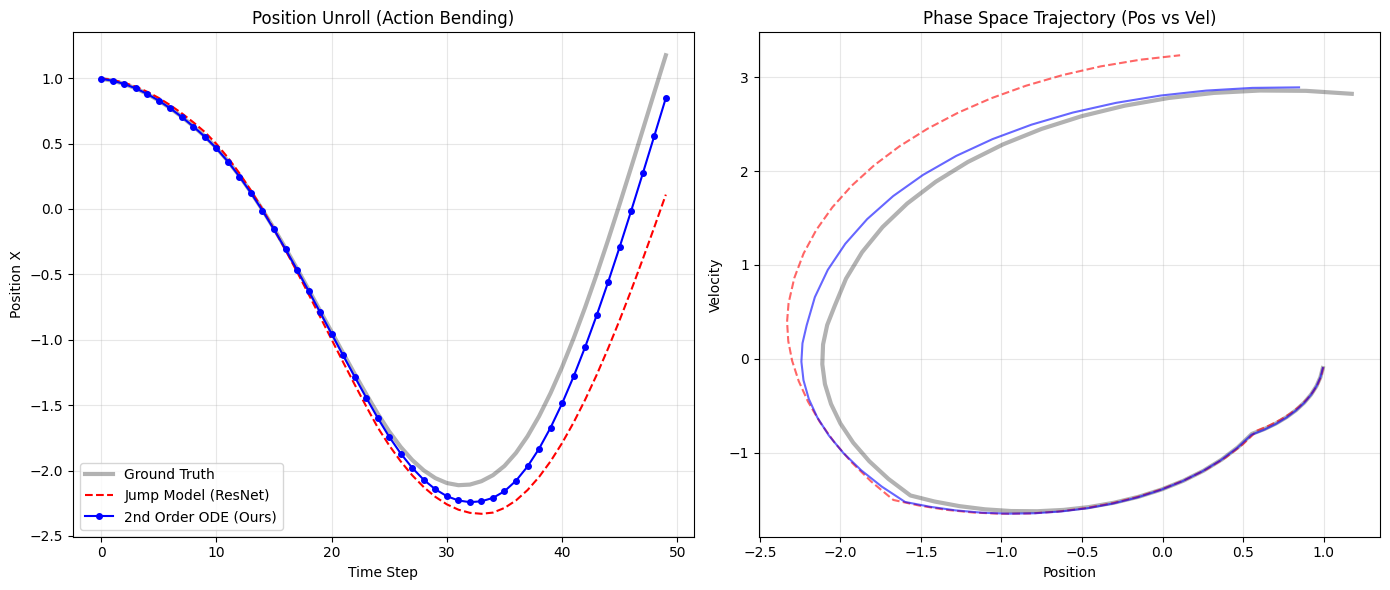

In [7]:
orig_dt_results = visualize_trajectory_unroll(
    jump_model,
    traj_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.1,
    c=0.1,
)

## Frame Rate Generalization

Dataset is generated at dt=0.1. Models trained at dt=0.1.


dt=0.2


Simulating Unroll for 50 steps...


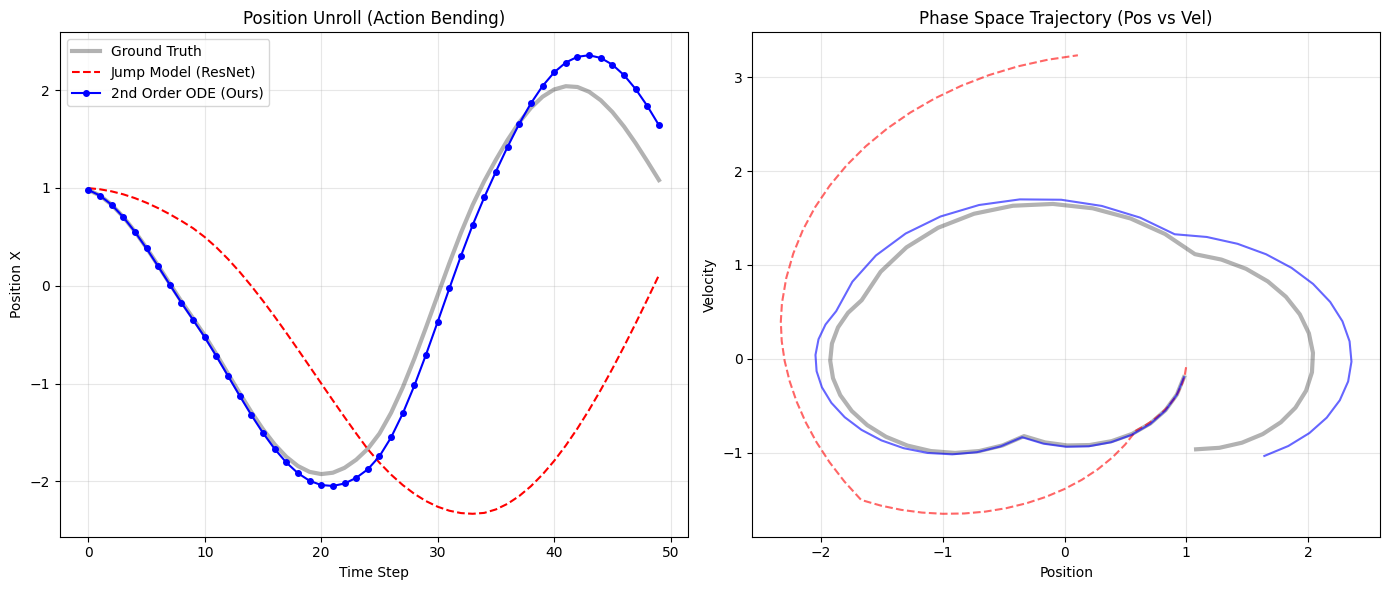

In [8]:
dt_02_results = visualize_trajectory_unroll(
    jump_model,
    traj_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.2,
    c=0.1,
)

dt=0.5


Simulating Unroll for 50 steps...


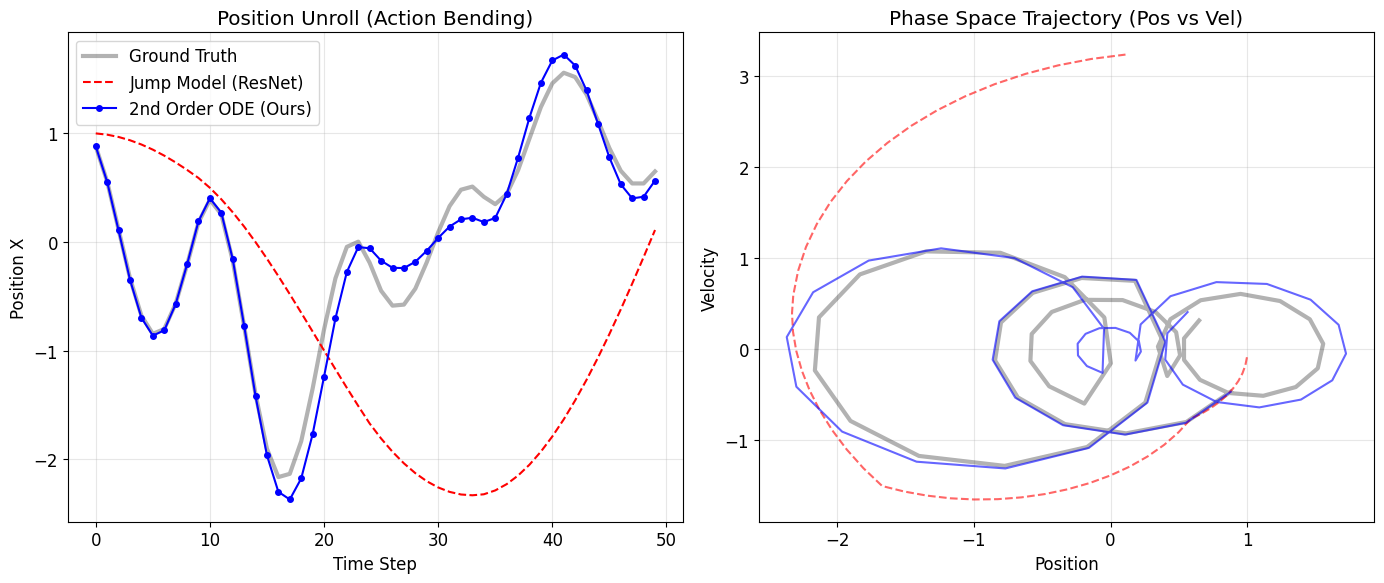

In [30]:
dt_05_results = visualize_trajectory_unroll(
    jump_model,
    traj_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.5,
    c=0.1,
)

dt=1


Simulating Unroll for 50 steps...


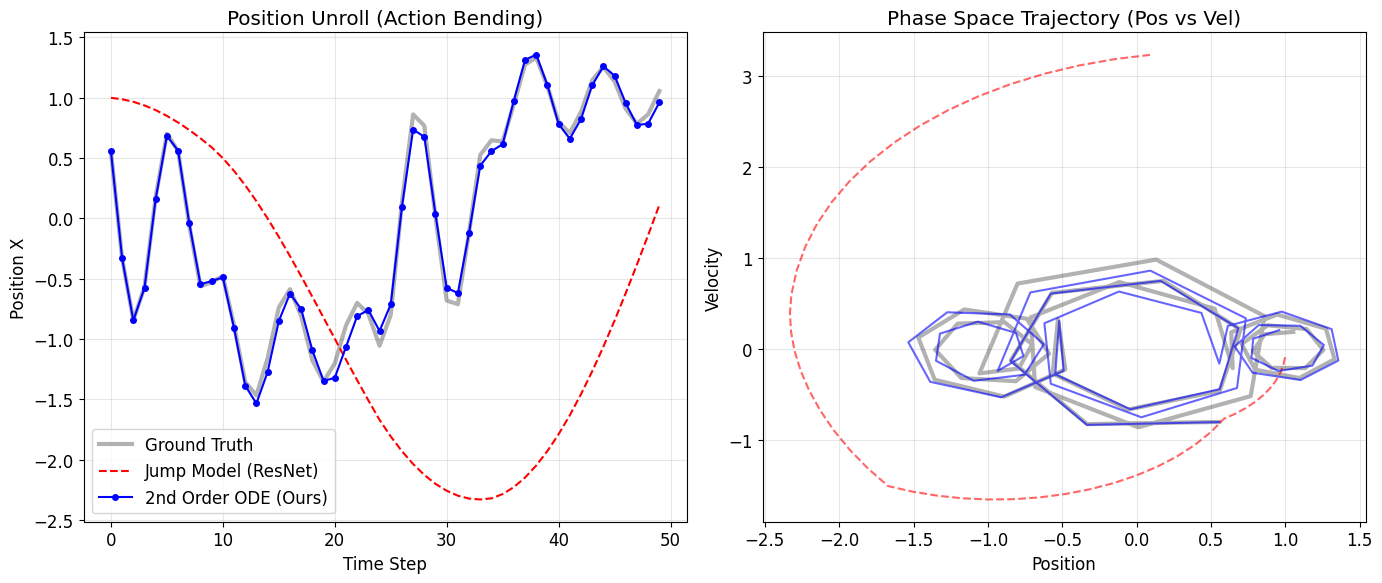

In [31]:
dt_1_results = visualize_trajectory_unroll(
    jump_model,
    traj_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=1,
    c=0.1,
)

dt=2


Simulating Unroll for 50 steps...


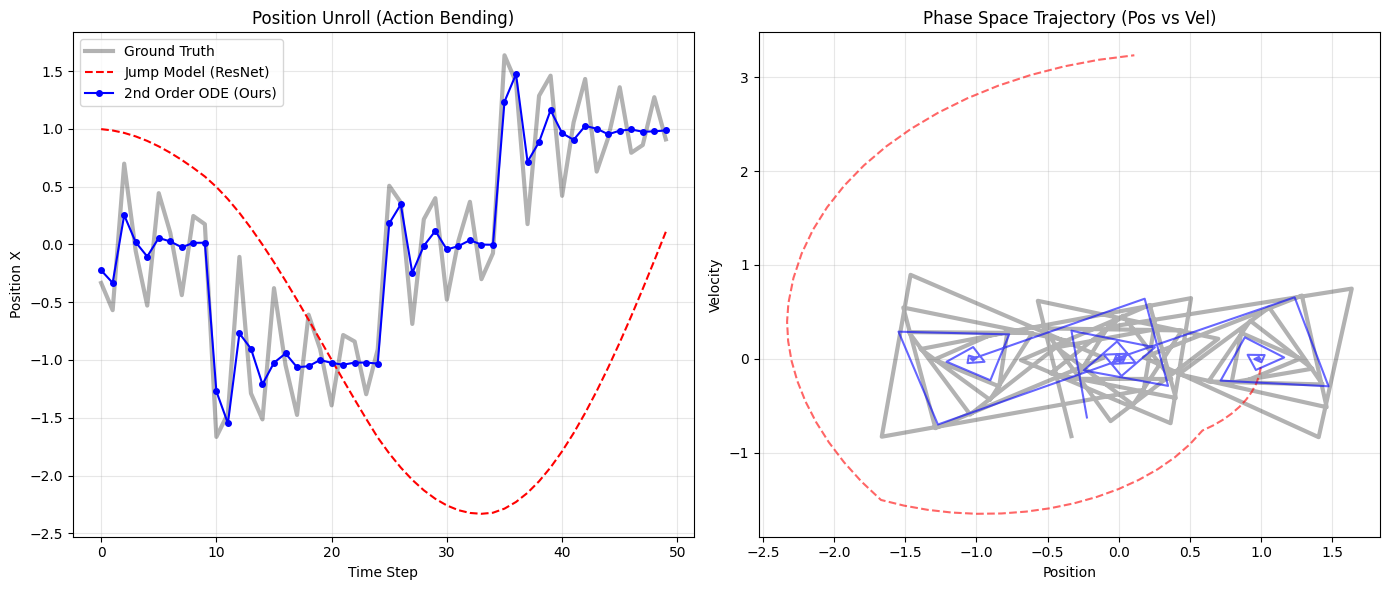

In [12]:
dt_2_results = visualize_trajectory_unroll(
    jump_model,
    traj_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=2,
    c=0.1,
)

Simulating Unroll for 50 steps...


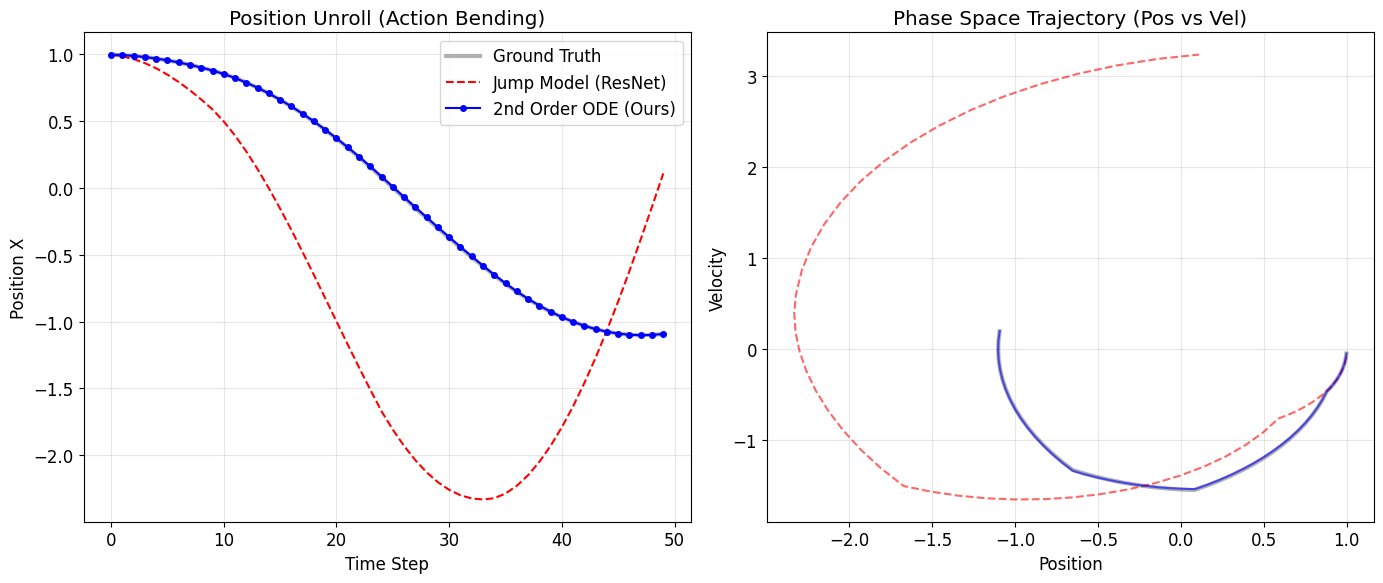

In [28]:
dt_20hz_results = visualize_trajectory_unroll(
    jump_model,
    traj_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.05,
    c=0.1,
)

In [ ]:
# using orig_dt_results, dt_02_results, dt_05_results, dt_1_results, dt_2_results, build a paper-ready figure (savable) that stacks the results vertically, showing \
# the position vs time for each framerate. include proper title, legends, clean colors/lines, axis, etc. 

Final figure saved as 'trajectory_matching_framerate_comparison_final.png' and '.pdf'


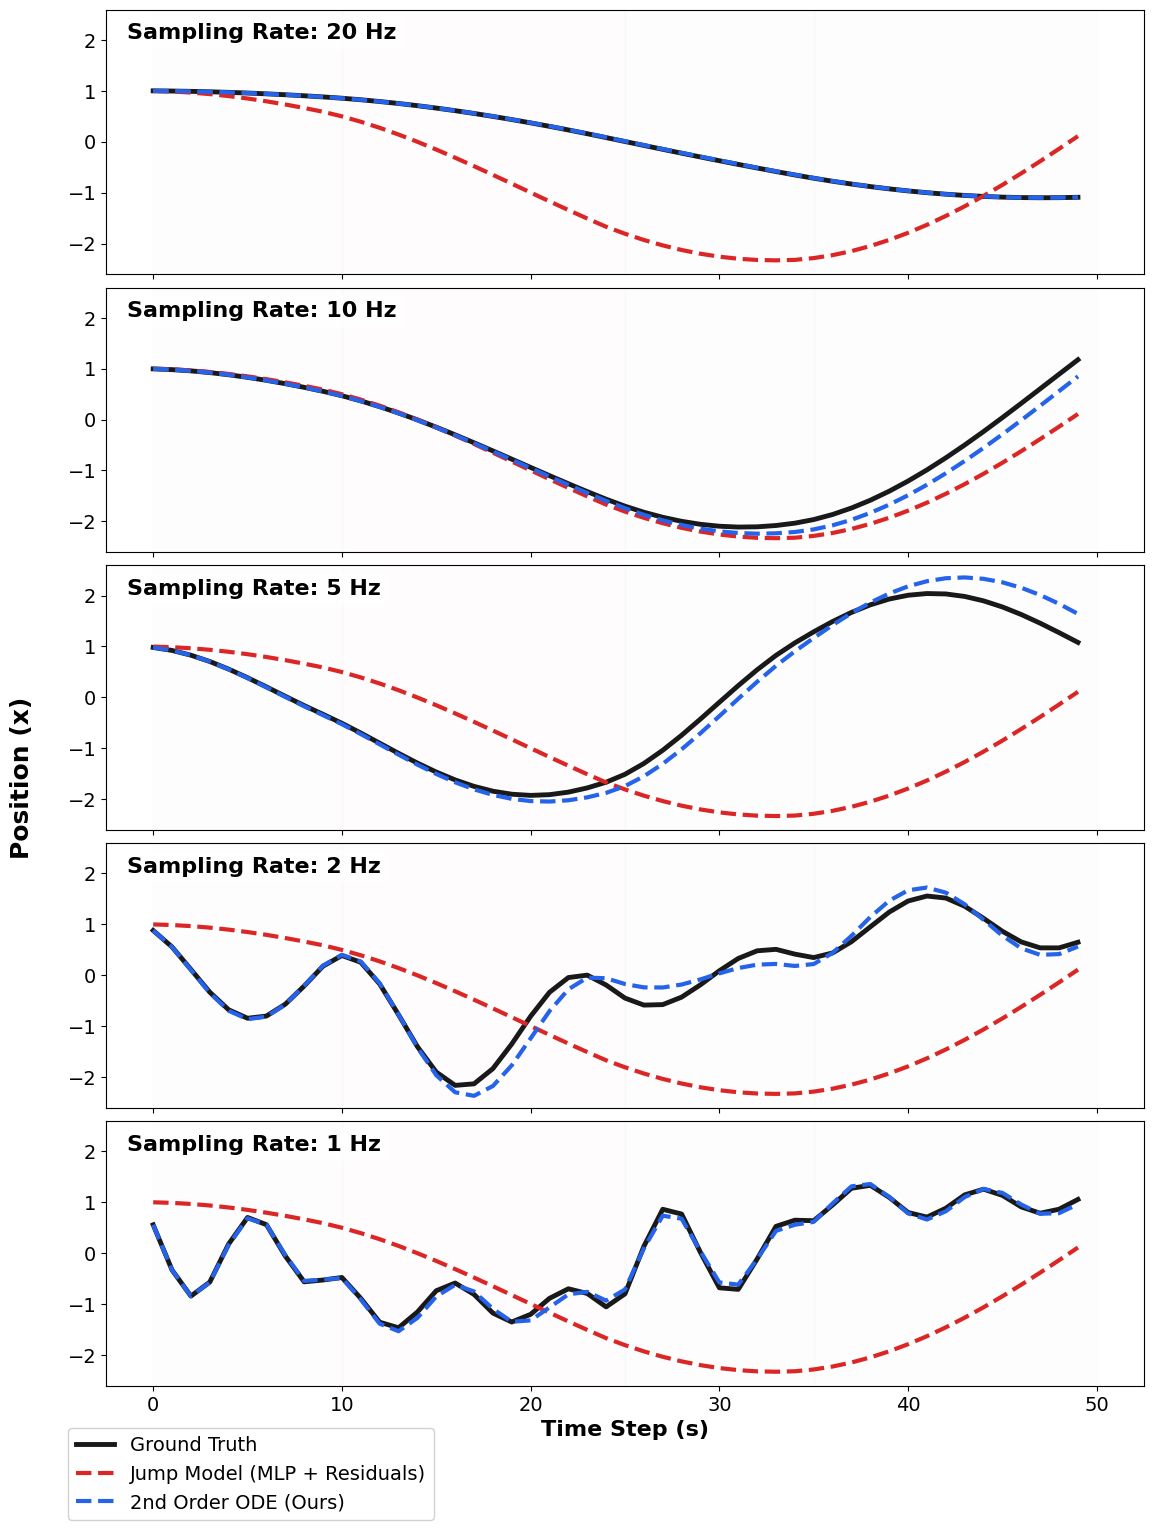

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming these variables are already defined from your experiments
# Each contains: (gt_hist, jump_hist, traj_hist, t_steps)

# Prepare the data - convert step sizes to sampling frequencies
# dt = 0.1 -> 10 Hz, dt = 0.2 -> 5 Hz, etc.
results = [
    ("20", dt_20hz_results),
    ("10", orig_dt_results),  # dt=0.1 -> 1/0.1 = 10 Hz
    ("5", dt_02_results),  # dt=0.2 -> 1/0.2 = 5 Hz
    ("2", dt_05_results),  # dt=0.5 -> 1/0.5 = 2 Hz
    ("1", dt_1_results),  # dt=1.0 -> 1/1.0 = 1 Hz
    # ("0.5", dt_2_results),  # dt=2.0 -> 1/2.0 = 0.5 Hz
]

# Create figure with 5 subplots stacked vertically
fig, axes = plt.subplots(5, 1, figsize=(12, 16), sharex=True, sharey=True)

# Brighter, bolder colors for better readability
colors = {
    "Ground Truth": "black",  # "#1F2937",  # Darker gray (more contrast)
    "Jump Model": "#DC2626",  # Bright red
    "ODE Model": "#2563EB",  # Bright blue
}

line_styles = {"Ground Truth": "-", "Jump Model": "--", "ODE Model": "--"}

line_widths = {"Ground Truth": 3.5, "Jump Model": 3.0, "ODE Model": 3.0}

# Plot each dt result
for i, (freq_value, result_data) in enumerate(results):
    ax = axes[i]

    # Unpack the result data
    gt_hist, jump_hist, traj_hist, t_steps = result_data

    # Convert to numpy arrays if needed
    gt_hist = np.array(gt_hist)
    jump_hist = np.array(jump_hist)
    traj_hist = np.array(traj_hist)
    t_steps = np.array(t_steps)

    # Plot position vs time for each model
    ax.plot(
        t_steps,
        gt_hist[:, 0],
        color=colors["Ground Truth"],
        linestyle=line_styles["Ground Truth"],
        linewidth=line_widths["Ground Truth"],
        alpha=0.9,
        label="Ground Truth",
    )

    ax.plot(
        t_steps,
        jump_hist[:, 0],
        color=colors["Jump Model"],
        linestyle=line_styles["Jump Model"],
        linewidth=line_widths["Jump Model"],
        label="Jump Model (MLP + Residuals)",
    )

    ax.plot(
        t_steps,
        traj_hist[:, 0],
        color=colors["ODE Model"],
        linestyle=line_styles["ODE Model"],
        linewidth=line_widths["ODE Model"],
        label="2nd Order ODE (Ours)",
    )

    # Add sampling rate text at top left of each subplot
    ax.text(
        0.02,
        0.95,
        f"Sampling Rate: {freq_value} Hz",
        transform=ax.transAxes,
        fontsize=16,
        fontweight="bold",
        verticalalignment="top",
        bbox=dict(
            boxstyle="round,pad=0.3",
            facecolor="white",
            alpha=0.8,
            edgecolor="none",
        ),
    )

    # Formatting
    ax.tick_params(axis="both", which="major", labelsize=14)

    # Remove grid
    ax.grid(False)

    # Add subtle background shading for different action phases
    # (based on the treatment pattern: wait, push left, wait, push right)
    treatment = {0: 15, 1: 10, 2: 15}  # From your experiment
    phase_starts = [
        0,
        treatment[1],
        treatment[1] + treatment[0],
        treatment[1] + treatment[0] + treatment[1],
    ]
    phase_labels = ["Wait", "Push Left", "Wait", "Push Right"]
    phase_colors = ["#ECEFF4", "#FCE4EC", "#ECEFF4", "#E8F5E8"]

    for j, (start, label) in enumerate(zip(phase_starts, phase_labels)):
        if j < len(phase_starts) - 1:
            end = phase_starts[j + 1]
        else:
            end = len(t_steps)
        ax.axvspan(
            start, end, alpha=0.1, color=phase_colors[j % len(phase_colors)]
        )

# Set common axis labels with larger font
fig.text(
    0.04,
    0.5,
    "Position (x)",
    va="center",
    rotation="vertical",
    fontsize=18,
    fontweight="bold",
)
axes[-1].set_xlabel("Time Step (s)", fontsize=16, fontweight="bold")

# Add legend to bottom left with proper spacing
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower left",
    bbox_to_anchor=(0.08, 0.03),
    fontsize=14,
    framealpha=0.9,
    ncol=1,
)

# Adjust layout with more bottom spacing for legend
plt.tight_layout()
plt.subplots_adjust(left=0.12, bottom=0.12, top=0.98, hspace=0.05)

# Save the figure
plt.savefig(
    "trajectory_matching_framerate_comparison_final.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
)
plt.savefig(
    "trajectory_matching_framerate_comparison_final.pdf",
    bbox_inches="tight",
    facecolor="white",
)

print(
    "Final figure saved as 'trajectory_matching_framerate_comparison_final.png' and '.pdf'"
)
plt.show()

## Trajectory Matching Predict K Steps


In [36]:
import torch
import torch.nn as nn
from torchdiffeq import odeint


class TrajectoryShootingModel(nn.Module):
    def __init__(self, ode_func, dt=0.1):
        super().__init__()
        self.ode_func = ode_func
        self.dt = dt

    def forward(self, start_state, action_seq, dt=None):
        """
        Simulates the trajectory for K steps.

        Args:
            start_state: [Batch, 2] (Position, Velocity)
            action_seq:  [Batch, K] (Indices of actions)

        Returns:
            pred_states: [Batch, K, 2] (The sequence of future states)
        """
        batch_size, K = action_seq.shape
        curr_state = start_state
        pred_states = []
        dt = self.dt if dt is None else dt

        # We define a fixed time span for ONE step [0, dt]
        # The solver restarts at t=0 for every segment (autonomous dynamics assumption)
        t_span = torch.tensor([0.0, dt], device=start_state.device)

        for k in range(K):
            # 1. Get Action for this step
            # action_seq[:, k] is the action to be applied from t to t+1
            step_action = action_seq[:, k]

            # 2. Get Embedding (needed for the ODE func)
            act_emb = self.ode_func.act_emb(step_action)

            # 3. Define the Dynamics Closure
            # This binds the specific action 'act_emb' to the function
            def func(t, y):
                return self.ode_func(t, y, act_emb, step_action)

            # 4. Integrate for one step (dt)
            # Input: [B, 2] -> Output: [2, B, 2] (Start and End)
            # We take index [-1] to get the End state
            next_state = odeint(func, curr_state, t_span, method="rk4")[-1]

            # 5. Store and Recurse
            pred_states.append(next_state)
            curr_state = next_state  # Pass momentum to next step

        # Stack into [Batch, K, 2]
        return torch.stack(pred_states, dim=1)


# ==========================================
# TRAINING LOOP UPDATE
# ==========================================
def train_sequence_experiment(
    dataset, epochs=50, batch_size=32, lr=1e-3, K_shooting=5
):
    # split dataset into train and test
    len_dataset = len(dataset)
    perm = np.random.permutation(len_dataset)
    train_indices = perm[: int(len_dataset * 0.8)]
    test_indices = perm[int(len_dataset * 0.8) :]
    train_dataset = [dataset[i] for i in train_indices]
    test_dataset = [dataset[i] for i in test_indices]

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )

    # Models
    ode_core = SecondOrderODENet()
    shooting_model = TrajectoryShootingModel(ode_core, dt=0.1)

    optimizer = optim.Adam(shooting_model.parameters(), lr=1e-3)

    def train_step(batch):
        # Full sequence from dataset
        states_full = batch["states"]  # [B, 20, 2]
        actions_full = batch["actions"]  # [B, 20]
        targets_full = batch["targets"]  # [B, 20, 2]
        B, T, D = states_full.shape

        # Randomly crop a K-step segment for training
        # (Start anywhere between 0 and 15)
        t_start = np.random.randint(0, T - K_shooting)

        # Inputs
        start_z = states_full[:, t_start, :]  # [B, 2]
        act_seq = actions_full[:, t_start : t_start + K_shooting]  # [B, K]

        # Targets (The sequence of ground truth states)
        target_seq = targets_full[
            :, t_start : t_start + K_shooting, :
        ]  # [B, K, 2]

        # Forward (Simulate K steps)
        pred_seq = shooting_model(start_z, act_seq)

        # Loss: Average MSE over all K steps
        # This forces the model to be accurate at t+1, t+2... t+K
        loss = ((pred_seq - target_seq) ** 2).mean()

        # Optional: Add Velocity Regularization to prevent exploding gradients
        # loss += 0.01 * (pred_seq[..., 1]**2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss.item()

    @torch.no_grad()
    def test_step(batch):
        states_full = batch["states"]  # [B, 20, 2]
        actions_full = batch["actions"]  # [B, 20]
        targets_full = batch["targets"]  # [B, 20, 2]
        B, T, D = states_full.shape

        t_start = np.random.randint(0, T - K_shooting)

        # Inputs
        start_z = states_full[:, t_start, :]  # [B, 2]
        act_seq = actions_full[:, t_start : t_start + K_shooting]  # [B, K]

        # Targets (The sequence of ground truth states)
        target_seq = targets_full[
            :, t_start : t_start + K_shooting, :
        ]  # [B, K, 2]

        # Forward (Simulate K steps)
        pred_seq = shooting_model(start_z, act_seq)

        # Loss: Average MSE over all K steps
        # This forces the model to be accurate at t+1, t+2... t+K
        loss = ((pred_seq - target_seq) ** 2).mean()
        return loss.item()

    print("Training with Sequence Shooting (K=5)...")

    # We will train on subsequences of length K=5 for stability
    pbar = tqdm(range(1, epochs + 1), desc=f"Epoch {1} | Seq Loss: 0.0000")

    for epoch in pbar:
        total_loss = 0

        for batch in train_loader:
            loss = train_step(batch)
            total_loss += loss

        epoch_loss = total_loss / len(train_loader)
        pbar.set_description(f"Epoch {epoch} | Seq Loss: {epoch_loss:.4f}")

    # test
    test_loss = 0
    for batch in test_loader:
        loss = test_step(batch)
        test_loss += loss

    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")

    return shooting_model

In [38]:
shooting_model = train_sequence_experiment(
    traj_dataset, epochs=100, batch_size=32, lr=1e-4, K_shooting=5
)

Training with Sequence Shooting (K=5)...


Epoch 100 | Seq Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 40.29it/s]

Test Loss: 0.0000


In [23]:
def visualize_shooting_unroll(
    jump_model,
    traj_model_1step,
    shooting_model_kstep,  # <--- Added K-step model
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.1,
    c=0.3,
    force_range=(-1, 1),  # Adjusted default to match physics class
):
    physics = ForcedOscillator(force_range=force_range)

    # 1. Warmup History
    state = torch.tensor([1.0, 0.0])

    # Initialize all models at the same start state
    curr_gt = state
    curr_jump = state.unsqueeze(0)
    curr_traj_1 = state.unsqueeze(0)
    curr_shoot_k = state.unsqueeze(0)  # <--- Added

    # 2. Define Action Sequence
    # Wait, Push Left, Wait, Push Right
    actions = (
        [1] * treatment[1]
        + [0] * treatment[0]
        + [1] * treatment[1]
        + [2] * treatment[2]
    )

    gt_hist = []
    jump_hist = []
    traj_1_hist = []
    shoot_k_hist = []  # <--- Added

    print(f"Simulating Unroll for {len(actions)} steps...")

    # 3. Unroll Loop
    for act_idx in actions:
        # A. Ground Truth Step
        curr_gt = physics.step(curr_gt, c, act_idx, dt)
        gt_hist.append(curr_gt.numpy())

        # B. Jump Model Step (Discrete Map)
        with torch.no_grad():
            act_tensor = torch.tensor([act_idx])
            curr_jump = jump_model(curr_jump, act_tensor)
            jump_hist.append(curr_jump[0].numpy())

        # C. Trajectory Model Step (1-Step Trained)
        with torch.no_grad():
            act_tensor = torch.tensor([act_idx])
            curr_traj_1 = traj_model_1step(curr_traj_1, act_tensor, dt=dt)
            traj_1_hist.append(curr_traj_1[0].numpy())

        # D. Shooting Model Step (K-Step Trained) <--- Added
        with torch.no_grad():
            # We treat it as a 1-step unroll here to test stability
            # Input expects [Batch, SeqLen], so we create [1, 1]
            act_seq = torch.tensor([[act_idx]])

            # Returns sequence of states [Batch, 1, 2]
            curr_shoot_seq = shooting_model_kstep(curr_shoot_k, act_seq)

            # Update current state (take the last/only step)
            curr_shoot_k = curr_shoot_seq[:, -1, :]
            shoot_k_hist.append(curr_shoot_k[0].numpy())

    # 4. Plotting
    gt_hist = np.array(gt_hist)
    jump_hist = np.array(jump_hist)
    traj_1_hist = np.array(traj_1_hist)
    shoot_k_hist = np.array(shoot_k_hist)

    t_steps = np.arange(len(actions))

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # --- Plot Position ---
    ax[0].plot(
        t_steps, gt_hist[:, 0], "k-", lw=4, alpha=0.2, label="Ground Truth"
    )
    ax[0].plot(
        t_steps, jump_hist[:, 0], "r--", lw=1.5, label="Jump Model (ResNet)"
    )
    ax[0].plot(
        t_steps,
        traj_1_hist[:, 0],
        "b-.",
        alpha=0.8,
        label="ODE (Trained 1-Step)",
    )
    ax[0].plot(
        t_steps,
        shoot_k_hist[:, 0],
        "g-",  # Green Solid
        lw=2,
        alpha=0.9,
        label="ODE (Shooting K-Step)",
    )

    ax[0].set_title("Position Unroll Comparison")
    ax[0].set_ylabel("Position X")
    ax[0].set_xlabel("Time Step")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # --- Plot Phase Space ---
    ax[1].plot(
        gt_hist[:, 0], gt_hist[:, 1], "k-", lw=4, alpha=0.2, label="GT Phase"
    )
    ax[1].plot(
        jump_hist[:, 0], jump_hist[:, 1], "r--", lw=1, alpha=0.5, label="Jump"
    )
    ax[1].plot(
        traj_1_hist[:, 0],
        traj_1_hist[:, 1],
        "b-.",
        lw=1,
        alpha=0.6,
        label="ODE 1-Step",
    )
    ax[1].plot(
        shoot_k_hist[:, 0],
        shoot_k_hist[:, 1],
        "g-",
        lw=2,
        alpha=0.8,
        label="ODE Shooting",
    )

    ax[1].set_title("Phase Space (Velocity vs Position)")
    ax[1].set_xlabel("Position")
    ax[1].set_ylabel("Velocity")
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Simulating Unroll for 50 steps...


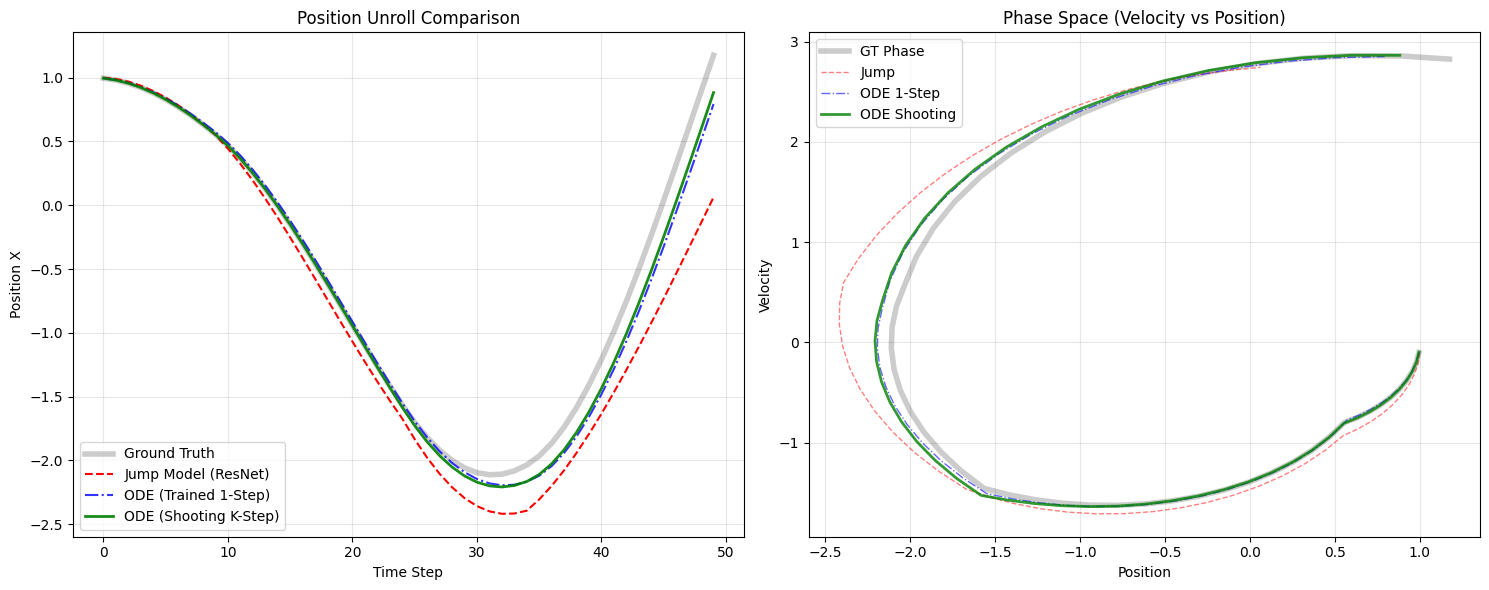

In [27]:
visualize_shooting_unroll(
    jump_model,
    traj_model,
    shooting_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.1,
    c=0.1,
    force_range=(-10, 10),
)

In [41]:
def visualize_shooting_k_analysis(
    jump_model,
    traj_model_1step,
    shooting_model_kstep,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.1,
    c=0.1,
    force_range=(-10, 10),
    K_horizon=5,  # The training horizon of the shooting model
    shoot_interval=5,  # How often to plot the lookahead
    show_traj_1_step=True,
):
    physics = ForcedOscillator(force_range=force_range)

    # 1. Setup & Warmup
    state = torch.tensor([1.0, 0.0])
    curr_gt = state
    curr_jump = state.unsqueeze(0)
    curr_traj_1 = state.unsqueeze(0)
    curr_shoot_auto = state.unsqueeze(0)

    # 2. Define Full Action Sequence
    actions = (
        [1] * treatment[1]
        + [0] * treatment[0]
        + [1] * treatment[1]
        + [2] * treatment[2]
    )

    # Storage for continuous paths
    gt_hist = []
    jump_hist = []
    traj_1_hist = []
    shoot_auto_hist = []

    # Storage for "Shooting Bursts" (List of [K, 2] arrays)
    shooting_bursts = []
    burst_start_times = []

    print(f"Simulating Unroll for {len(actions)} steps...")

    # 3. Main Simulation Loop
    for t, act_idx in enumerate(actions):

        # --- A. Record History ---
        gt_hist.append(curr_gt.numpy())
        jump_hist.append(curr_jump[0].numpy())
        traj_1_hist.append(curr_traj_1[0].numpy())
        shoot_auto_hist.append(curr_shoot_auto[0].numpy())

        # --- B. The "Shooting" Lookahead ---
        # Every 'shoot_interval' steps, predict K steps into the future
        # starting from the GROUND TRUTH state (to check physics accuracy)
        if t % shoot_interval == 0 and t + K_horizon < len(actions):
            # 1. Get Action Sequence for next K steps
            act_seq_k = torch.tensor([actions[t : t + K_horizon]])  # [1, K]

            # 2. Get Current GT State
            curr_gt_tensor = curr_gt.unsqueeze(0)  # [1, 2]

            # 3. Predict K steps at once
            with torch.no_grad():
                # Output: [1, K, 2]
                burst_pred = shooting_model_kstep(
                    curr_gt_tensor, act_seq_k, dt
                )

            # 4. Store for plotting
            shooting_bursts.append(burst_pred[0].numpy())
            burst_start_times.append(t)

        # --- C. Step all models forward (Autoregressive) ---

        # Ground Truth
        curr_gt = physics.step(curr_gt, c, act_idx, dt)

        # Jump Model
        with torch.no_grad():
            act_tensor = torch.tensor([act_idx])
            curr_jump = jump_model(curr_jump, act_tensor)

        # 1-Step ODE
        with torch.no_grad():
            act_tensor = torch.tensor([act_idx])
            curr_traj_1 = traj_model_1step(curr_traj_1, act_tensor, dt=dt)

        # Shooting ODE (Used Autoregressively here for comparison)
        with torch.no_grad():
            act_seq_1 = torch.tensor([[act_idx]])
            curr_shoot_auto = shooting_model_kstep(
                curr_shoot_auto, act_seq_1, dt
            )[:, -1, :]

    # 4. Plotting
    gt_hist = np.array(gt_hist)
    jump_hist = np.array(jump_hist)
    traj_1_hist = np.array(traj_1_hist)
    shoot_auto_hist = np.array(shoot_auto_hist)
    t_steps = np.arange(len(actions))

    if show_traj_1_step:
        shoot_auto_hist = traj_1_hist

    fig, ax = plt.subplots(1, 2, figsize=(16, 7))

    # === PLOT 1: Position Time Series ===
    # Main Lines
    ax[0].plot(
        t_steps, gt_hist[:, 0], "k-", lw=3, alpha=0.3, label="Ground Truth"
    )
    ax[0].plot(
        t_steps, jump_hist[:, 0], "r--", lw=1, alpha=0.5, label="Jump (ResNet)"
    )
    ax[0].plot(
        t_steps,
        shoot_auto_hist[:, 0],
        "g-",
        lw=1.5,
        alpha=0.6,
        label="Shooting (Autoregressive)",
    )

    # Plot Shooting Bursts
    # This loop plots the K-step predictions
    for i, burst in enumerate(shooting_bursts):
        start_t = burst_start_times[i]
        # Create time axis for this burst: [t+1, ..., t+K]
        burst_times = np.arange(start_t + 1, start_t + K_horizon + 1)

        # Plot segment
        label = "Shooting (K-Step Lookahead)" if i == 0 else None
        ax[0].plot(
            burst_times, burst[:, 0], "c-o", markersize=3, lw=2, label=label
        )

        # Draw a connector from start point
        ax[0].plot(
            [start_t, start_t + 1],
            [gt_hist[start_t, 0], burst[0, 0]],
            "c:",
            lw=1,
        )

    ax[0].set_title(f"Shooting Method Analysis (K={K_horizon})")
    ax[0].set_ylabel("Position X")
    ax[0].set_xlabel("Time Step")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # === PLOT 2: Phase Space ===
    ax[1].plot(
        gt_hist[:, 0], gt_hist[:, 1], "k-", lw=3, alpha=0.2, label="GT Phase"
    )
    ax[1].plot(
        shoot_auto_hist[:, 0],
        shoot_auto_hist[:, 1],
        "g-",
        lw=1,
        alpha=0.4,
        label="Shooting (Auto)",
    )

    # Plot Bursts in Phase Space
    for i, burst in enumerate(shooting_bursts):
        start_t = burst_start_times[i]
        # Insert the starting GT point so the line connects to the path
        start_pt = gt_hist[start_t]

        # Concat [Start, Pred1, Pred2... PredK]
        full_burst = np.concatenate([start_pt.reshape(1, 2), burst], axis=0)

        ax[1].plot(full_burst[:, 0], full_burst[:, 1], "c-", lw=2, alpha=0.8)
        ax[1].plot(
            burst[-1, 0], burst[-1, 1], "c.", markersize=5
        )  # Mark end of prediction

    ax[1].set_title("Phase Space: K-Step Flow")
    ax[1].set_xlabel("Position")
    ax[1].set_ylabel("Velocity")
    # Custom legend for phase space to avoid clutter
    from matplotlib.lines import Line2D

    custom_lines = [
        Line2D([0], [0], color="k", lw=3, alpha=0.2),
        Line2D([0], [0], color="g", lw=1),
        Line2D([0], [0], color="c", lw=2),
    ]
    ax[1].legend(
        custom_lines,
        ["Ground Truth", "Continuous Rollout", "K-Step Predictions"],
    )
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Simulating Unroll for 50 steps...


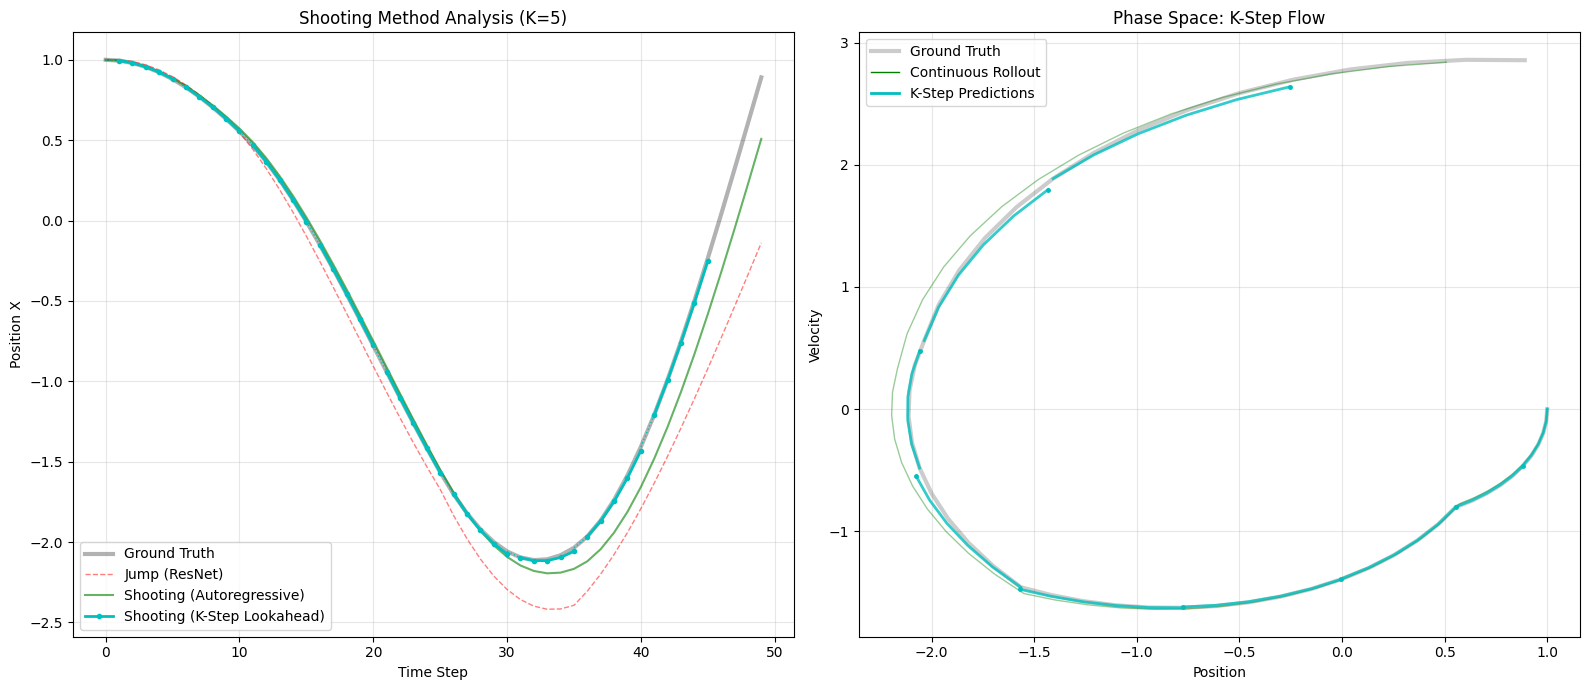

In [42]:
visualize_shooting_k_analysis(
    jump_model,
    traj_model,
    shooting_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.1,
)

Simulating Unroll for 50 steps...


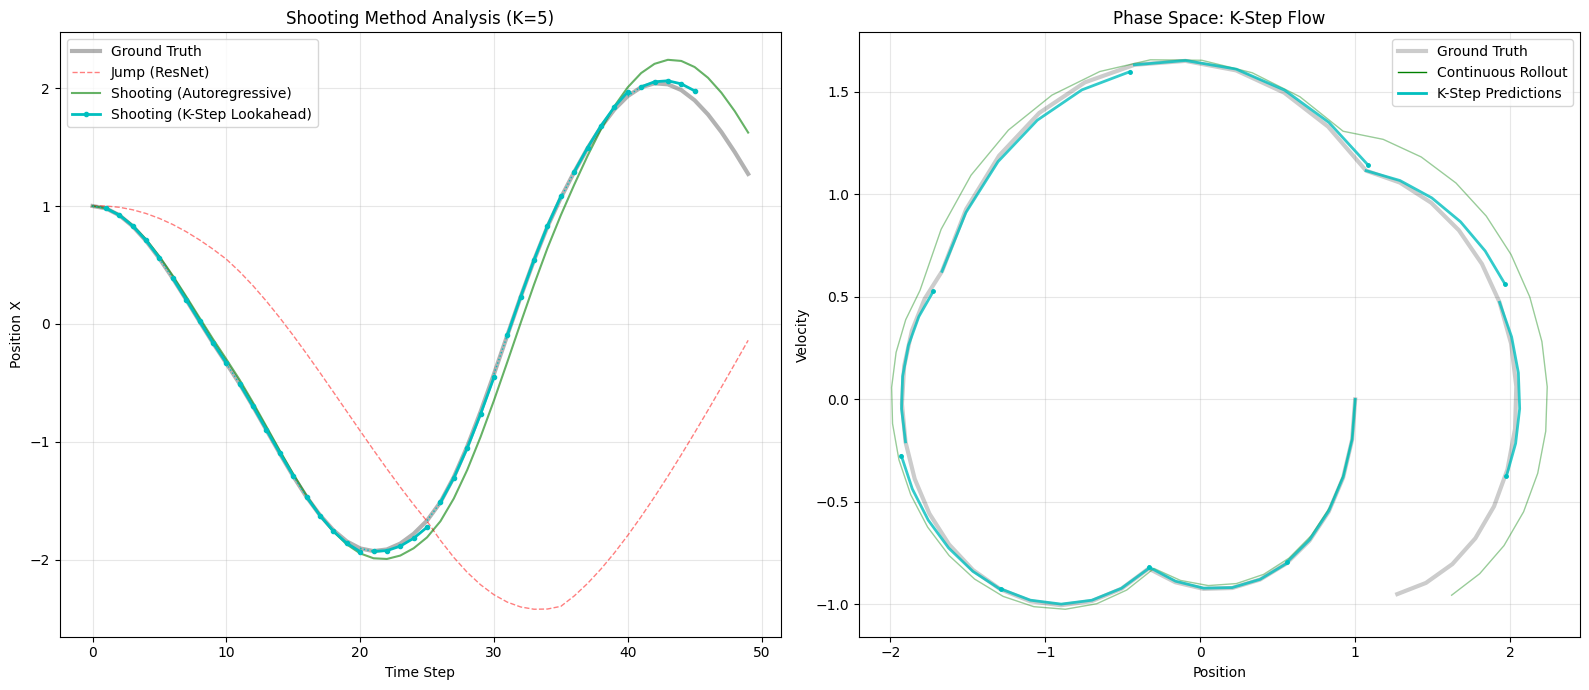

In [43]:
visualize_shooting_k_analysis(
    jump_model,
    traj_model,
    shooting_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.2,
)

Simulating Unroll for 50 steps...


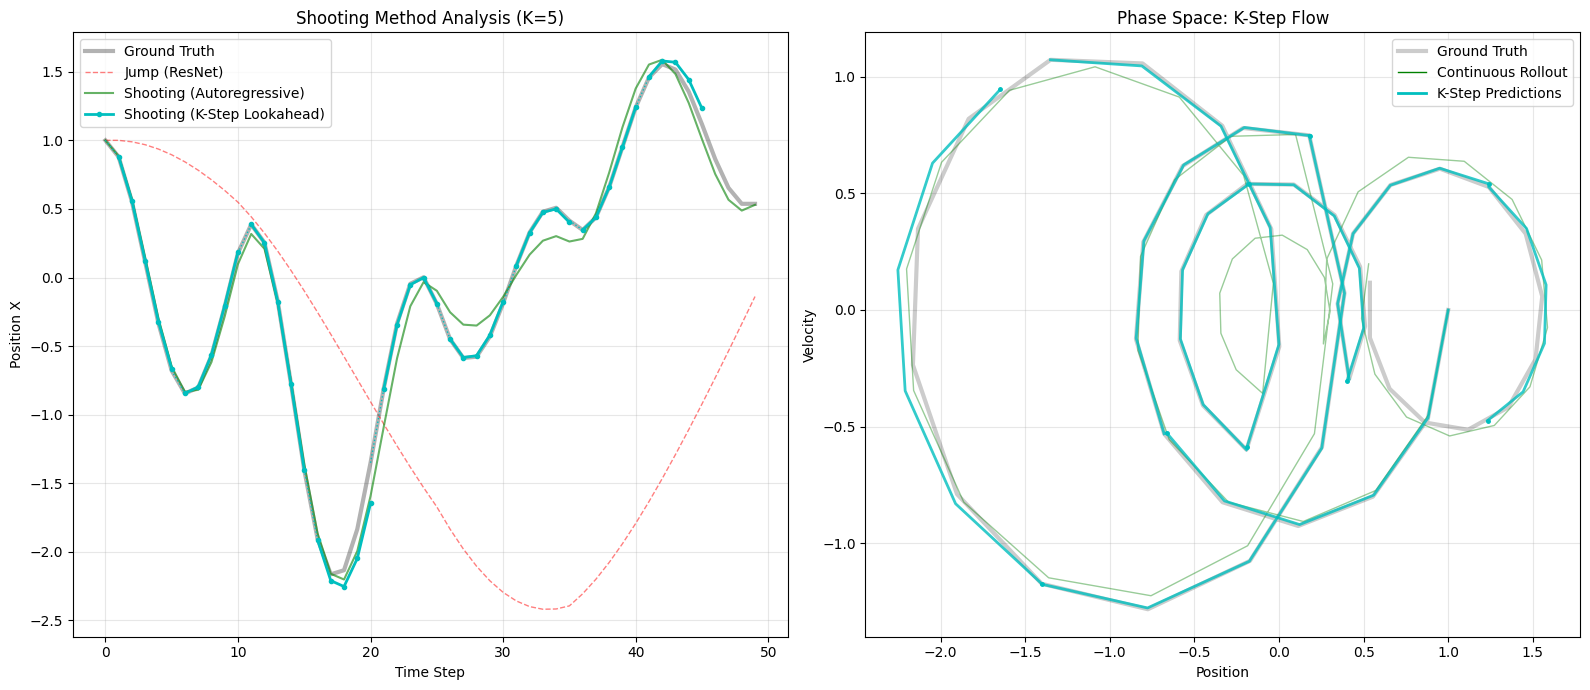

In [44]:
visualize_shooting_k_analysis(
    jump_model,
    traj_model,
    shooting_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.5,
)

In [45]:
traj_dataset_5hz = SequenceDataset(
    n_seqs=200,
    seq_len=100,
    dt=0.1,
    m=1.0,
    k=1.0,
    c_range=(0.1, 0.1),
)

Generating 200 sequences of length 100...


In [46]:
jump_model_5hz, traj_model_5hz = train_experiment(
    traj_dataset_5hz, epochs=100, batch_size=32, lr=1e-4
)

Training Models...


Epoch 100 | Jump Loss: 0.0000 | Traj Loss: 0.0000:   0%|          | 0/100 [00:04<?, ?it/s]

Testing Models...
Test | Jump Loss: 0.0000 | Traj Loss: 0.0021


Simulating Unroll for 50 steps...


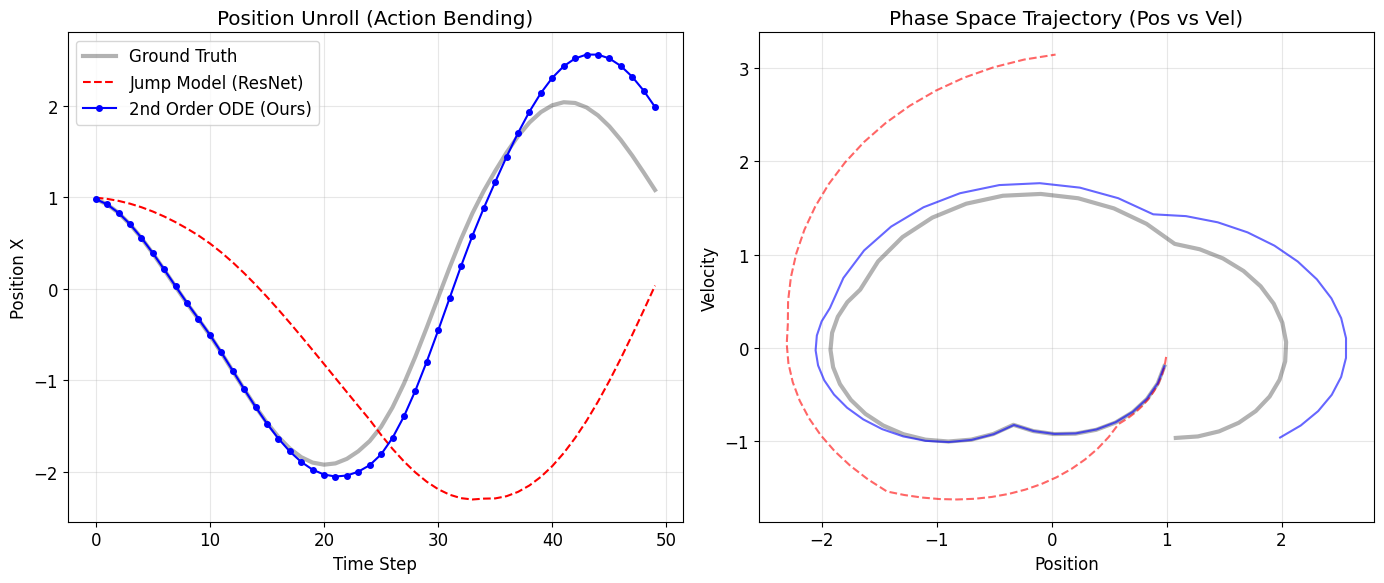

In [48]:
trained_5hz_results = visualize_trajectory_unroll(
    jump_model_5hz,
    traj_model_5hz,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.2,
    c=0.1,
)

Simulating Unroll for 50 steps...


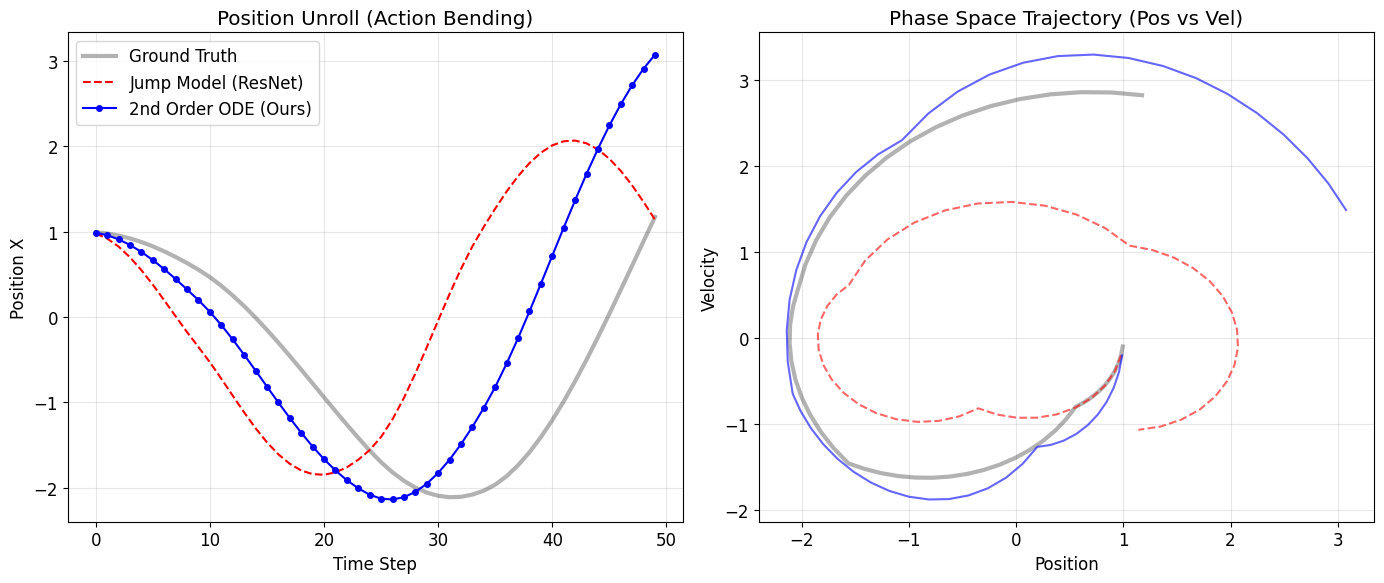

In [41]:
trained_5hz_results_test_10hz = visualize_trajectory_unroll(
    jump_model_5hz,
    traj_model_5hz,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.1,
    c=0.1,
)

# 2D Planar Oscillator: Energy Drift Analysis

Training models...
Running Long-Horizon Energy Drift Test...


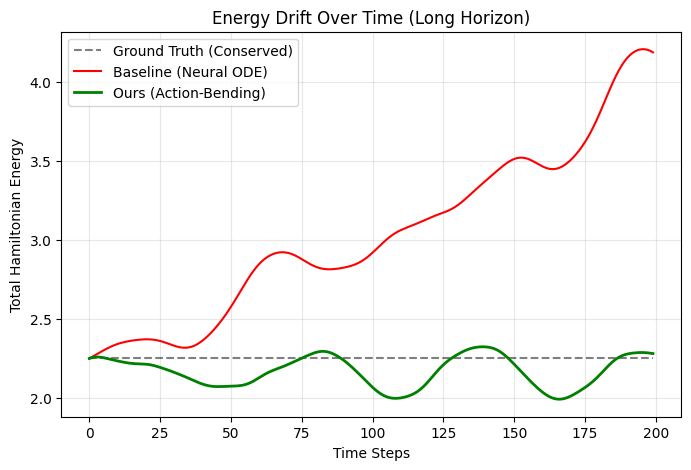

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint


# ==========================================
# 1. 2D PHYSICS ENGINE (Conservative)
# ==========================================
class PlanarOscillator:
    def __init__(self, k=1.0):
        self.k = k  # Spring constant
        # Actions: [0: Coast, 1: Up, 2: Down, 3: Left, 4: Right]
        self.action_vecs = torch.tensor(
            [[0.0, 0.0], [0.0, 1.0], [0.0, -1.0], [-1.0, 0.0], [1.0, 0.0]]
        )

    def get_energy(self, state):
        """Hamiltonian = 0.5*v^2 + 0.5*k*x^2"""
        x = state[..., 0:2]
        v = state[..., 2:4]
        kinetic = 0.5 * (v**2).sum(dim=-1)
        potential = 0.5 * self.k * (x**2).sum(dim=-1)
        return kinetic + potential

    def step(self, state, action_idx, dt=0.1):
        """Ground Truth Dynamics"""
        u = self.action_vecs[action_idx]

        def dynamics(t, s):
            x, v = s[..., 0:2], s[..., 2:4]
            dxdt = v
            # F_net = F_action - k*x (No damping for energy test)
            dvdt = u - self.k * x
            return torch.cat([dxdt, dvdt], dim=-1)

        return odeint(
            dynamics, state, torch.tensor([0.0, dt]), method="dopri5"
        )[-1]


# ==========================================
# 2. DATASET
# ==========================================
class OscillatorDataset(Dataset):
    def __init__(self, n_seqs=100, seq_len=50, dt=0.1):
        self.data = []
        physics = PlanarOscillator()

        for _ in range(n_seqs):
            # Start at random position on the unit circle
            theta = np.random.uniform(0, 2 * np.pi)
            r = np.random.uniform(1.0, 2.0)
            x_init = torch.tensor(
                [
                    r * np.cos(theta),
                    r * np.sin(theta),
                    -r * np.sin(theta),
                    r * np.cos(theta),
                ]
            )  # Orbit velocity

            states, actions = [x_init], []
            curr = x_init

            for _ in range(seq_len):
                # Randomly steer or coast
                a = np.random.randint(0, 5)
                curr = physics.step(curr, a, dt)
                states.append(curr)
                actions.append(a)

            self.data.append(
                {
                    "states": torch.stack(states[:-1]).float(),
                    "actions": torch.tensor(actions).long(),
                    "targets": torch.stack(states[1:]).float(),
                }
            )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# ==========================================
# 3. MODELS
# ==========================================


# --- Baseline: Unconstrained Neural ODE ---
class BaselineNode(nn.Module):
    def __init__(self):
        super().__init__()
        self.act_emb = nn.Embedding(5, 16)
        self.net = nn.Sequential(
            nn.Linear(4 + 16, 64),
            nn.Tanh(),
            nn.Linear(64, 2),  # Outputs Acceleration directly
        )

    def forward(self, t, state, action_emb):
        x, v = state[..., 0:2], state[..., 2:4]
        # Simply predicts acceleration from state + action
        acc = self.net(torch.cat([x, v, action_emb], dim=-1))
        return torch.cat([v, acc], dim=-1)


# --- Ours: Symplectic Action-Bending ---
class ActionBendingNode(nn.Module):
    def __init__(self):
        super().__init__()
        self.act_emb = nn.Embedding(5, 16)

        # 1. Learn Potential U(x) -> Scalar
        self.potential_net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(), nn.Linear(64, 1)
        )

        # 2. Learn Action Force (Raw)
        self.control_net = nn.Sequential(
            nn.Linear(4 + 16, 64), nn.Tanh(), nn.Linear(64, 2)
        )

    def forward(self, t, state, action_emb):
        # Enable grad for Potential calculation
        with torch.enable_grad():
            x = state[..., 0:2].requires_grad_(True)
            v = state[..., 2:4]

            # A. Conservative Force: F = -Grad(U)
            # We predict Potential Energy U, then take derivative w.r.t x
            u_val = self.potential_net(x).sum()
            grad_u = torch.autograd.grad(u_val, x, create_graph=True)[0]
            f_env = -grad_u

            # B. Action Bending
            f_raw = self.control_net(torch.cat([x, v, action_emb], dim=-1))

            # Projection: F_bend = F_raw - (F_raw . v / |v|^2) * v
            v_sq = (v**2).sum(dim=-1, keepdim=True) + 1e-6
            proj = (f_raw * v).sum(dim=-1, keepdim=True) / v_sq
            f_bend = f_raw - (proj * v)

            # Total Acceleration
            acc = f_env + f_bend

        return torch.cat([v, acc], dim=-1)


# Wrapper for ODE Integration
class NeuralODEWrapper(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, state, action_idx, dt=0.1):
        emb = self.func.act_emb(action_idx)

        def f(t, y):
            return self.func(t, y, emb)

        return odeint(f, state, torch.tensor([0.0, dt]), method="rk4")[-1]


# ==========================================
# 4. EXPERIMENT: ENERGY DRIFT
# ==========================================
def run_comparison():
    # Generate Data
    dataset = OscillatorDataset(n_seqs=50, seq_len=20)
    loader = DataLoader(dataset, batch_size=16, shuffle=True)

    # Init Models
    baseline = NeuralODEWrapper(BaselineNode())
    ours = NeuralODEWrapper(ActionBendingNode())

    opt_b = optim.Adam(baseline.parameters(), lr=1e-3)
    opt_o = optim.Adam(ours.parameters(), lr=1e-3)

    # Training Loop (Brief)
    print("Training models...")
    for epoch in range(50):
        for batch in loader:
            s, a, t = batch["states"], batch["actions"], batch["targets"]

            # Flatten for 1-step training
            s_flat, a_flat, t_flat = s.view(-1, 4), a.view(-1), t.view(-1, 4)

            # Train Baseline
            pred_b = baseline(s_flat, a_flat)
            loss_b = ((pred_b - t_flat) ** 2).mean()
            opt_b.zero_grad()
            loss_b.backward()
            opt_b.step()

            # Train Ours
            pred_o = ours(s_flat, a_flat)
            loss_o = ((pred_o - t_flat) ** 2).mean()
            opt_o.zero_grad()
            loss_o.backward()
            opt_o.step()

    # --- THE CRITICAL TEST: Long Horizon Drift ---
    print("Running Long-Horizon Energy Drift Test...")
    physics = PlanarOscillator()

    # Initial State [x=1.5, y=0, vx=0, vy=1.5] (Circular Orbit ish)
    start = torch.tensor([[1.5, 0.0, 0.0, 1.5]])

    # Action Sequence: Coasting (Action 0) for 200 steps
    # We test "Coasting" because that's where drift is most obvious
    actions = torch.zeros(200).long()

    curr_b, curr_o = start.clone(), start.clone()
    energies_b, energies_o, energies_gt = [], [], []

    for a in actions:
        # Calculate Energy
        energies_gt.append(physics.get_energy(start).item())  # Constant
        energies_b.append(physics.get_energy(curr_b).item())
        energies_o.append(physics.get_energy(curr_o).item())

        # Step
        with torch.no_grad():
            curr_b = baseline(curr_b, a.unsqueeze(0))
            curr_o = ours(curr_o, a.unsqueeze(0))

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(energies_gt, "k--", label="Ground Truth (Conserved)", alpha=0.5)
    plt.plot(energies_b, "r-", label="Baseline (Neural ODE)")
    plt.plot(energies_o, "g-", linewidth=2, label="Ours (Action-Bending)")
    plt.title("Energy Drift Over Time (Long Horizon)")
    plt.ylabel("Total Hamiltonian Energy")
    plt.xlabel("Time Steps")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig("energy_drift.png", dpi=300)
    plt.show()


run_comparison()

Starting 5 experimental runs to generate error bounds...


100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


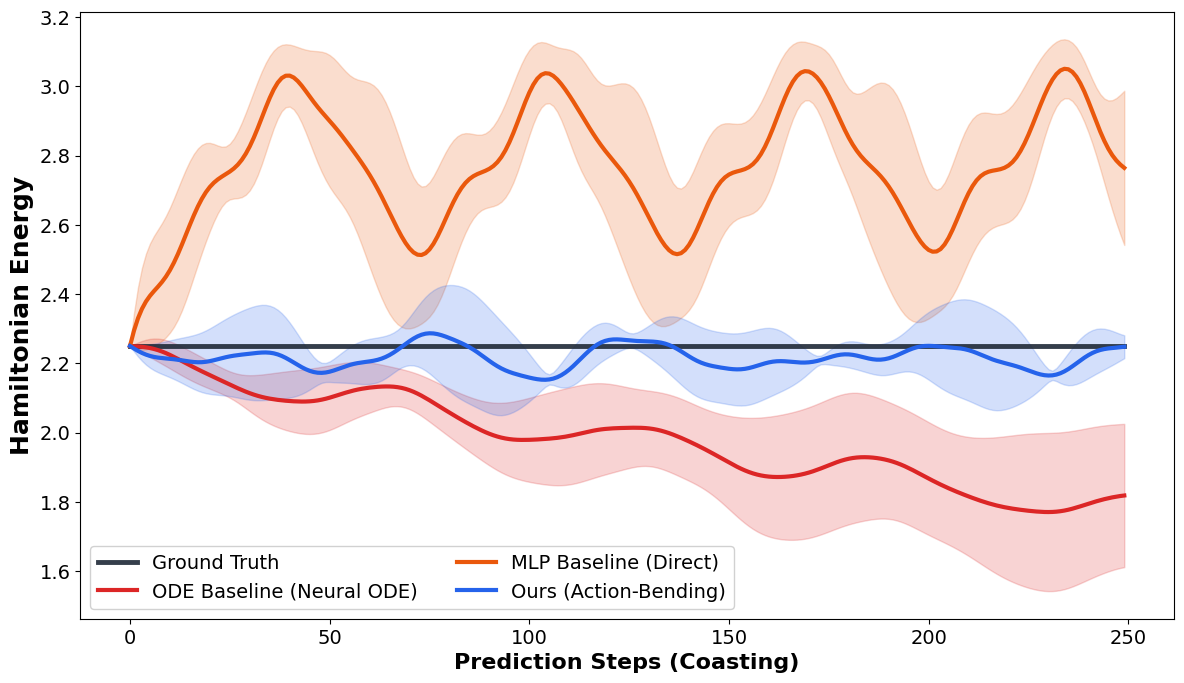

Plot saved as 'energy_stability_bounds_three_baselines.png'


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from tqdm import tqdm  # For progress bars


# ==========================================
# 1. 2D PHYSICS ENGINE (Conservative)
# ==========================================
class PlanarOscillator:
    def __init__(self, k=1.0):
        self.k = k  # Spring constant
        # Actions: [0: Coast, 1: Up, 2: Down, 3: Left, 4: Right]
        self.action_vecs = torch.tensor(
            [[0.0, 0.0], [0.0, 1.0], [0.0, -1.0], [-1.0, 0.0], [1.0, 0.0]]
        )

    def get_energy(self, state):
        """Hamiltonian = 0.5*v^2 + 0.5*k*x^2"""
        x = state[..., 0:2]
        v = state[..., 2:4]
        kinetic = 0.5 * (v**2).sum(dim=-1)
        potential = 0.5 * self.k * (x**2).sum(dim=-1)
        return kinetic + potential

    def step(self, state, action_idx, dt=0.1):
        """Ground Truth Dynamics"""
        u = self.action_vecs[action_idx]

        def dynamics(t, s):
            x, v = s[..., 0:2], s[..., 2:4]
            dxdt = v
            # F_net = F_action - k*x (No damping for energy test)
            dvdt = u - self.k * x
            return torch.cat([dxdt, dvdt], dim=-1)

        return odeint(
            dynamics, state, torch.tensor([0.0, dt]), method="dopri5"
        )[-1]


# ==========================================
# 2. DATASET
# ==========================================
class OscillatorDataset(Dataset):
    def __init__(self, n_seqs=100, seq_len=20, dt=0.1):
        self.data = []
        physics = PlanarOscillator()

        for _ in range(n_seqs):
            # Start at random position on the unit circle
            theta = np.random.uniform(0, 2 * np.pi)
            r = np.random.uniform(1.0, 2.0)
            x_init = torch.tensor(
                [
                    r * np.cos(theta),
                    r * np.sin(theta),
                    -r * np.sin(theta),
                    r * np.cos(theta),
                ]
            )  # Orbit velocity

            states, actions = [x_init], []
            curr = x_init

            for _ in range(seq_len):
                # Randomly steer or coast
                a = np.random.randint(0, 5)
                curr = physics.step(curr, a, dt)
                states.append(curr)
                actions.append(a)

            self.data.append(
                {
                    "states": torch.stack(states[:-1]).float(),
                    "actions": torch.tensor(actions).long(),
                    "targets": torch.stack(states[1:]).float(),
                }
            )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# ==========================================
# 3. MODELS
# ==========================================


# --- Baseline 1: Unconstrained Neural ODE ---
class BaselineNode(nn.Module):
    def __init__(self):
        super().__init__()
        self.act_emb = nn.Embedding(5, 16)
        self.net = nn.Sequential(
            nn.Linear(4 + 16, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2),  # Outputs Acceleration directly
        )

    def forward(self, t, state, action_emb):
        x, v = state[..., 0:2], state[..., 2:4]
        # Simply predicts acceleration from state + action
        acc = self.net(torch.cat([x, v, action_emb], dim=-1))
        return torch.cat([v, acc], dim=-1)


# --- Baseline 2: Simple MLP (Direct State Prediction) ---
class MLPBaseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.act_emb = nn.Embedding(5, 16)
        self.net = nn.Sequential(
            nn.Linear(4 + 16, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 4),  # Directly outputs next state
        )

    def forward(self, state, action_idx):
        emb = self.act_emb(action_idx)
        return self.net(torch.cat([state, emb], dim=-1))


# --- Ours: Symplectic Action-Bending ---
class ActionBendingNode(nn.Module):
    def __init__(self):
        super().__init__()
        self.act_emb = nn.Embedding(5, 16)

        # 1. Learn Potential U(x) -> Scalar
        self.potential_net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
        )

        # 2. Learn Action Force (Raw)
        self.control_net = nn.Sequential(
            nn.Linear(4 + 16, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2),
        )

    def forward(self, t, state, action_emb):
        # Enable grad for Potential calculation
        with torch.enable_grad():
            x = state[..., 0:2].requires_grad_(True)
            v = state[..., 2:4]

            # A. Conservative Force: F = -Grad(U)
            # We predict Potential Energy U, then take derivative w.r.t x
            u_val = self.potential_net(x).sum()
            grad_u = torch.autograd.grad(u_val, x, create_graph=True)[0]
            f_env = -grad_u

            # B. Action Bending
            f_raw = self.control_net(torch.cat([x, v, action_emb], dim=-1))

            # Projection: F_bend = F_raw - (F_raw . v / |v|^2) * v
            # Add epsilon to prevent div by zero
            v_sq = (v**2).sum(dim=-1, keepdim=True) + 1e-6
            proj = (f_raw * v).sum(dim=-1, keepdim=True) / v_sq
            f_bend = f_raw - (proj * v)

            # Total Acceleration
            acc = f_env + f_bend

        return torch.cat([v, acc], dim=-1)


# Wrapper for ODE Integration
class NeuralODEWrapper(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, state, action_idx, dt=0.1):
        emb = self.func.act_emb(action_idx)

        def f(t, y):
            return self.func(t, y, emb)

        return odeint(f, state, torch.tensor([0.0, dt]), method="rk4")[-1]


# ==========================================
# 4. EXPERIMENT LOOP: MULTI-SEED
# ==========================================
def train_and_evaluate_single_run(run_id, steps=200):
    """
    Trains one instance of both models and returns their energy trajectories.
    """
    # 1. Setup Data
    dataset = OscillatorDataset(n_seqs=50, seq_len=20)
    loader = DataLoader(dataset, batch_size=16, shuffle=True)

    # 2. Init Models
    baseline_ode = NeuralODEWrapper(BaselineNode())
    mlp_baseline = MLPBaseline()
    ours = NeuralODEWrapper(ActionBendingNode())

    opt_ode = optim.Adam(baseline_ode.parameters(), lr=2e-3)
    opt_mlp = optim.Adam(mlp_baseline.parameters(), lr=2e-3)
    opt_o = optim.Adam(ours.parameters(), lr=2e-3)

    # 3. Train
    epochs = 40
    # Silent training to avoid clutter
    for _ in range(epochs):
        for batch in loader:
            s, a, t = batch["states"], batch["actions"], batch["targets"]
            s_flat, a_flat, t_flat = s.view(-1, 4), a.view(-1), t.view(-1, 4)

            # Baseline ODE Update
            pred_ode = baseline_ode(s_flat, a_flat)
            loss_ode = ((pred_ode - t_flat) ** 2).mean()
            opt_ode.zero_grad()
            loss_ode.backward()
            opt_ode.step()

            # MLP Baseline Update
            pred_mlp = mlp_baseline(s_flat, a_flat)
            loss_mlp = ((pred_mlp - t_flat) ** 2).mean()
            opt_mlp.zero_grad()
            loss_mlp.backward()
            opt_mlp.step()

            # Ours Update
            pred_o = ours(s_flat, a_flat)
            loss_o = ((pred_o - t_flat) ** 2).mean()
            # Optional: Add small regularization to potential to keep it centered
            opt_o.zero_grad()
            loss_o.backward()
            opt_o.step()

    # 4. Long Horizon Test
    physics = PlanarOscillator()

    # Standard start state for all runs to compare drift
    start = torch.tensor([[1.5, 0.0, 0.0, 1.5]])
    actions = torch.zeros(steps).long()  # Coasting

    curr_ode, curr_mlp, curr_o = start.clone(), start.clone(), start.clone()
    e_ode, e_mlp, e_o, e_gt = [], [], [], []

    # Initial Energy
    h0 = physics.get_energy(start).item()

    with torch.no_grad():
        for i, a in enumerate(actions):
            # Store normalized energy (H / H0)
            e_gt.append(physics.get_energy(start).item())
            e_ode.append(physics.get_energy(curr_ode).item())
            e_mlp.append(physics.get_energy(curr_mlp).item())
            e_o.append(physics.get_energy(curr_o).item())

            # Step
            a_in = a.unsqueeze(0)
            curr_ode = baseline_ode(curr_ode, a_in)
            curr_mlp = mlp_baseline(curr_mlp, a_in)
            curr_o = ours(curr_o, a_in)

    return e_ode, e_mlp, e_o, e_gt


def run_multi_seed_experiment(num_runs=5, steps=200):
    print(f"Starting {num_runs} experimental runs to generate error bounds...")

    results_ode = []
    results_mlp = []
    results_ours = []
    ground_truth = None

    for i in tqdm(range(num_runs)):
        e_ode, e_mlp, e_o, e_gt = train_and_evaluate_single_run(i, steps=steps)
        results_ode.append(e_ode)
        results_mlp.append(e_mlp)
        results_ours.append(e_o)
        ground_truth = e_gt  # Ground truth is constant/same

    # Convert to numpy for stats
    res_ode = np.array(results_ode)  # [Runs, Steps]
    res_mlp = np.array(results_mlp)
    res_o = np.array(results_ours)

    # Calculate Stats
    mu_ode, std_ode = res_ode.mean(axis=0), res_ode.std(axis=0)
    mu_mlp, std_mlp = res_mlp.mean(axis=0), res_mlp.std(axis=0)
    mu_o, std_o = res_o.mean(axis=0), res_o.std(axis=0)

    # Plotting
    plot_results(
        mu_ode, std_ode, mu_mlp, std_mlp, mu_o, std_o, ground_truth, steps
    )

    return mu_ode, std_ode, mu_mlp, std_mlp, mu_o, std_o, ground_truth, steps


def plot_results(mu_ode, std_ode, mu_mlp, std_mlp, mu_o, std_o, gt, steps):
    x = np.arange(steps)

    plt.figure(figsize=(12, 7))

    # Brighter, bolder colors for better readability (matching the position figure)
    colors = {
        "Ground Truth": "#1F2937",  # Darker gray (more contrast)
        "ODE Baseline": "#DC2626",  # Bright red
        "MLP Baseline": "#EA580C",  # Orange
        "Ours": "#2563EB",  # Bright blue
    }

    # 1. Ground Truth
    plt.plot(
        x,
        gt,
        color=colors["Ground Truth"],
        linestyle="-",
        linewidth=3.5,
        label="Ground Truth",
        alpha=0.9,
    )

    # 2. ODE Baseline
    plt.plot(
        x,
        mu_ode,
        color=colors["ODE Baseline"],
        linewidth=3.0,
        label="ODE Baseline (Neural ODE)",
    )
    plt.fill_between(
        x,
        mu_ode - std_ode,
        mu_ode + std_ode,
        color=colors["ODE Baseline"],
        alpha=0.2,
    )

    # 3. MLP Baseline
    plt.plot(
        x,
        mu_mlp,
        color=colors["MLP Baseline"],
        linewidth=3.0,
        label="MLP Baseline (Direct)",
    )
    plt.fill_between(
        x,
        mu_mlp - std_mlp,
        mu_mlp + std_mlp,
        color=colors["MLP Baseline"],
        alpha=0.2,
    )

    # 4. Ours
    plt.plot(
        x,
        mu_o,
        color=colors["Ours"],
        linewidth=3.0,
        label="Ours (Action-Bending)",
    )
    plt.fill_between(
        x, mu_o - std_o, mu_o + std_o, color=colors["Ours"], alpha=0.2
    )

    # Remove title, remove grid, increase font sizes to match position figure
    plt.ylabel("Hamiltonian Energy", fontsize=18, fontweight="bold")
    plt.xlabel("Prediction Steps (Coasting)", fontsize=16, fontweight="bold")
    plt.legend(loc="lower left", fontsize=14, framealpha=0.9, ncol=2)
    plt.tick_params(axis="both", which="major", labelsize=14)

    # Remove grid
    plt.grid(False)

    plt.tight_layout()

    # Save or Show
    plt.savefig("energy_stability_bounds_three_baselines.png", dpi=300)
    plt.show()
    print("Plot saved as 'energy_stability_bounds_three_baselines.png'")


mu_ode, std_ode, mu_mlp, std_mlp, mu_o, std_o, ground_truth, steps = (
    run_multi_seed_experiment(num_runs=5, steps=250)
)

In [20]:
def plot_results(mu_b, std_b, mu_o, std_o, gt, steps):
    x = np.arange(steps)

    plt.figure(figsize=(10, 6))

    # Brighter, bolder colors for better readability (matching the position figure)
    colors = {
        "Ground Truth": "#1F2937",  # Darker gray (more contrast)
        "Baseline": "#DC2626",  # Bright red
        "Ours": "#2563EB",  # Bright blue
    }

    # 1. Ground Truth
    plt.plot(
        x,
        gt,
        color=colors["Ground Truth"],
        linestyle="-",
        linewidth=3.5,
        label="Ground Truth",
        alpha=0.9,
    )

    # 2. Baseline
    plt.plot(
        x,
        mu_b,
        color=colors["Baseline"],
        linewidth=3.0,
        label="Baseline (Neural ODE)",
    )
    plt.fill_between(
        x, mu_b - std_b, mu_b + std_b, color=colors["Baseline"], alpha=0.2
    )

    # 3. Ours
    plt.plot(
        x,
        mu_o,
        color=colors["Ours"],
        linewidth=3.0,
        label="Ours (Action-Bending)",
    )
    plt.fill_between(
        x, mu_o - std_o, mu_o + std_o, color=colors["Ours"], alpha=0.2
    )

    # Remove title, remove grid, increase font sizes to match position figure
    plt.ylabel("Hamiltonian Energy", fontsize=18, fontweight="bold")
    plt.xlabel("Prediction Steps (Coasting)", fontsize=16, fontweight="bold")
    plt.legend(loc="lower left", fontsize=14, framealpha=0.9)
    plt.tick_params(axis="both", which="major", labelsize=14)

    # Remove grid
    plt.grid(False)

    plt.tight_layout()

    # Save or Show
    plt.savefig("energy_stability_bounds.png", dpi=300)
    plt.show()
    print("Plot saved as 'energy_stability_bounds.png'")

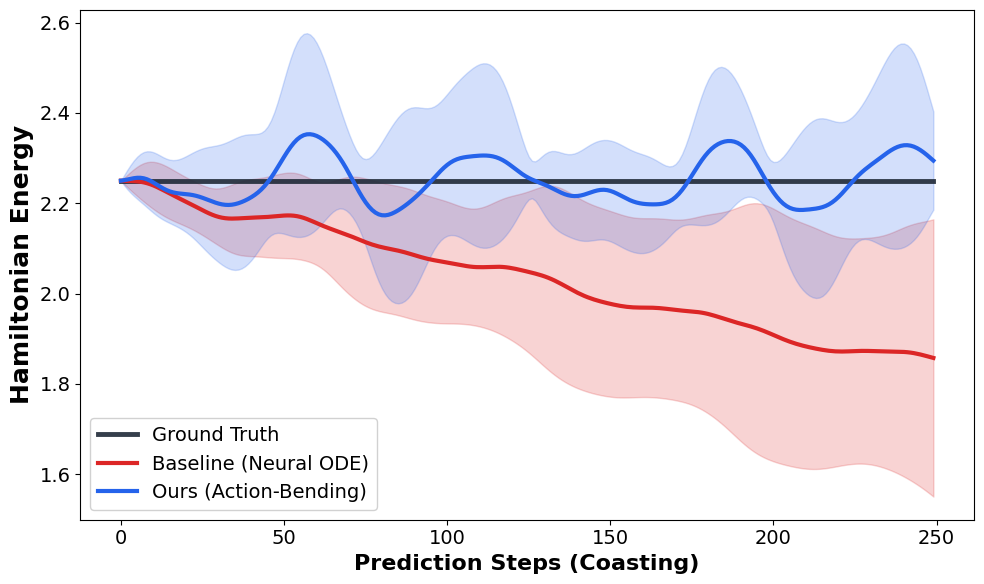

Plot saved as 'energy_stability_bounds.png'


In [21]:
plot_results(mu, std, mu_o, std_o, ground_truth, steps)